## Re-run all the tuning process on Fashion-MNIST data

In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Markdown, display

### Load Dataset

In [3]:
fmnist = tf.keras.datasets.fashion_mnist #28x28 spatial dimension, 1 color dimension (28x28x1), 10 classes (10 different clothing objects)

(fx_train, fy_train), (fx_test, fy_test) = fmnist.load_data()
fx_train, fx_test = fx_train / 255.0, fx_test / 255.0

In [4]:
display(Markdown('**Data Description**'))
display(Markdown(f"Training sample size: {fx_train.shape[0]}"), 
Markdown(f"Testing sample size: {fx_test.shape[0]}"))

**Data Description**

Training sample size: 60000

Testing sample size: 10000

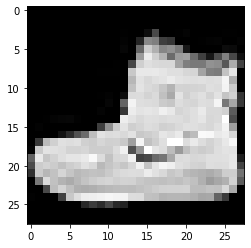

In [5]:
image = fx_train[0]
plt.imshow(image, cmap='gray')
plt.show()

### Model 1: Baseline Model
- Unregularized MLP with 2 hidden layers with 16 uints and ReLU activations
- Params
    + 100 epochs
    + Optimizer: Adam
    + Batch size = 128

**Network Architecture**

- Input Layer
  + Input size = (28, 28)

- Flatten input for Fully Connected Network

- Hidden Layer 1
  + Dense Layer
  + Units = 16
  + Activation: ReLU

- Hidden Layer 2
  + Dense Layer
  + Units = 16
  + Activation: ReLU

- Output Layer
  + Output size = (10)
  + Activation: Softmax

In [6]:
# fully connected model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape= (28,28)),                                
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy']
              )

display(Markdown("default hyperparameters for `Adam` optimizer:"),
        Markdown("`tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')`"))

# define params

num_epochs = 100
batch= 128

# Fit the model on training data
base_start= time.time()
history = model.fit(fx_train, fy_train, epochs=num_epochs, batch_size=batch, validation_split=0.2)
base_end = time.time()

display(Markdown(f"Training time: {base_end-base_start : .4f}s"))

default hyperparameters for `Adam` optimizer:

`tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')`

Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 0.8647 - sparse_categorical_accuracy: 0.6986 - val_loss: 0.5635 - val_sparse_categorical_accuracy: 0.8027
Epoch 2/100
375/375 [==============================] - 1s 1ms/step - loss: 0.5048 - sparse_categorical_accuracy: 0.8303 - val_loss: 0.4908 - val_sparse_categorical_accuracy: 0.8273
Epoch 3/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4531 - sparse_categorical_accuracy: 0.8433 - val_loss: 0.4605 - val_sparse_categorical_accuracy: 0.8353
Epoch 4/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4289 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.4405 - val_sparse_categorical_accuracy: 0.8462
Epoch 5/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4168 - sparse_categorical_accuracy: 0.8558 - val_loss: 0.4284 - val_sparse_categorical_accuracy: 0.8508
Epoch 6/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4035 - sparse_cate

Training time:  53.1005s

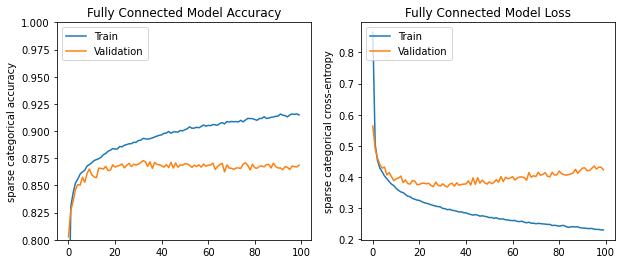

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Fully Connected Model Accuracy')
plt.xlabel=('epochs')
plt.ylabel('sparse categorical accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0.8, 1)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Fully Connected Model Loss')
plt.xlabel=('epochs')
plt.ylabel('sparse categorical cross-entropy')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.savefig('model_performance.png');

In [8]:
# Evaluate the model on testing data
test_loss, test_accuracy = model.evaluate(fx_test, fy_test, verbose= 1) 
display(Markdown(f"Testing loss : {test_loss: .4f}"),
        Markdown(f"Testing accuracy: {test_accuracy: .4f}"))

313/313 [==============================] - 0s 854us/step - loss: 0.4351 - sparse_categorical_accuracy: 0.8668


Testing loss :  0.4351

Testing accuracy:  0.8668

**Results:** The model is overfitting even more than on the handwritten MNIST dataset, we need early stopping and other measures that would prevent model from overfitting

### Complex Models

#### Early Stopping patience size
We need early stopping callback since running all 100epochs will be computationally expensive and will overfit. In the basline model above, after 100 epochs it was evident that the model was overfitting.
In implementing early stopping, we are trying to figure out which patience size will be best, trying on the baseline model for computational efficiency purposes.

In [9]:
#regularization with early stopping (figuring out patience parameter)
nets = 5
e_model = [0]*nets
patience = [1,2,3,4,5]
output_list_e = []

start_full_e = time.time()
for j in range(5):
    e_model[j] = tf.keras.models.Sequential()
    e_model[j].add(tf.keras.layers.Flatten(input_shape=(28,28)))
    e_model[j].add(tf.keras.layers.Dense(16, activation='relu'))
    e_model[j].add(tf.keras.layers.Dense(16,activation='relu'))
    e_model[j].add(tf.keras.layers.Dense(10, activation='softmax'))
    
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience[j]) 
    e_model[j].compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

    start= time.time()
    output_list_e.append(e_model[j].fit(fx_train, fy_train, validation_split=0.2,epochs=100, batch_size=128,callbacks= early_stop))
    end = time.time()
    display(Markdown(f"**Patience** = {patience[j]};  **Training time** = {end-start: .3f} s;  **Epochs** = {len(output_list_e[j].epoch)}"))

end_full_e = time.time()

Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 0.8150 - sparse_categorical_accuracy: 0.7196 - val_loss: 0.5294 - val_sparse_categorical_accuracy: 0.8158
Epoch 2/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4967 - sparse_categorical_accuracy: 0.8266 - val_loss: 0.4814 - val_sparse_categorical_accuracy: 0.8294
Epoch 3/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4454 - sparse_categorical_accuracy: 0.8435 - val_loss: 0.4439 - val_sparse_categorical_accuracy: 0.8467
Epoch 4/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4197 - sparse_categorical_accuracy: 0.8528 - val_loss: 0.4214 - val_sparse_categorical_accuracy: 0.8506
Epoch 5/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4016 - sparse_categorical_accuracy: 0.8579 - val_loss: 0.4112 - val_sparse_categorical_accuracy: 0.8531
Epoch 6/100
375/375 [==============================] - 1s 1ms/step - loss: 0.3915 - sparse_cate

**Patience** = 1;  **Training time** =  4.552 s;  **Epochs** = 8

Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 0.8685 - sparse_categorical_accuracy: 0.7111 - val_loss: 0.5480 - val_sparse_categorical_accuracy: 0.8023
Epoch 2/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4979 - sparse_categorical_accuracy: 0.8294 - val_loss: 0.4760 - val_sparse_categorical_accuracy: 0.8291
Epoch 3/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4516 - sparse_categorical_accuracy: 0.8451 - val_loss: 0.4343 - val_sparse_categorical_accuracy: 0.8495
Epoch 4/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4235 - sparse_categorical_accuracy: 0.8532 - val_loss: 0.4251 - val_sparse_categorical_accuracy: 0.8494
Epoch 5/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4095 - sparse_categorical_accuracy: 0.8574 - val_loss: 0.4109 - val_sparse_categorical_accuracy: 0.8602
Epoch 6/100
375/375 [==============================] - 1s 1ms/step - loss: 0.3976 - sparse_cate

**Patience** = 2;  **Training time** =  7.217 s;  **Epochs** = 13

Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 0.9568 - sparse_categorical_accuracy: 0.6972 - val_loss: 0.5469 - val_sparse_categorical_accuracy: 0.8123
Epoch 2/100
375/375 [==============================] - 1s 1ms/step - loss: 0.5067 - sparse_categorical_accuracy: 0.8259 - val_loss: 0.4765 - val_sparse_categorical_accuracy: 0.8362
Epoch 3/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4580 - sparse_categorical_accuracy: 0.8400 - val_loss: 0.4604 - val_sparse_categorical_accuracy: 0.8370
Epoch 4/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4316 - sparse_categorical_accuracy: 0.8501 - val_loss: 0.4411 - val_sparse_categorical_accuracy: 0.8444
Epoch 5/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4145 - sparse_categorical_accuracy: 0.8553 - val_loss: 0.4186 - val_sparse_categorical_accuracy: 0.8541
Epoch 6/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4042 - sparse_cate

**Patience** = 3;  **Training time** =  11.137 s;  **Epochs** = 20

Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 0.9062 - sparse_categorical_accuracy: 0.6963 - val_loss: 0.5519 - val_sparse_categorical_accuracy: 0.8147
Epoch 2/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4981 - sparse_categorical_accuracy: 0.8305 - val_loss: 0.4669 - val_sparse_categorical_accuracy: 0.8367
Epoch 3/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4501 - sparse_categorical_accuracy: 0.8445 - val_loss: 0.4466 - val_sparse_categorical_accuracy: 0.8428
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 0.4249 - sparse_categorical_accuracy: 0.8507 - val_loss: 0.4298 - val_sparse_categorical_accuracy: 0.8476
Epoch 5/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4073 - sparse_categorical_accuracy: 0.8565 - val_loss: 0.4162 - val_sparse_categorical_accuracy: 0.8521
Epoch 6/100
375/375 [==============================] - 1s 1ms/step - loss: 0.3951 - sparse_cate

**Patience** = 4;  **Training time** =  11.502 s;  **Epochs** = 20

Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 0.7977 - sparse_categorical_accuracy: 0.7308 - val_loss: 0.5292 - val_sparse_categorical_accuracy: 0.8162
Epoch 2/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4861 - sparse_categorical_accuracy: 0.8323 - val_loss: 0.4688 - val_sparse_categorical_accuracy: 0.8370
Epoch 3/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4432 - sparse_categorical_accuracy: 0.8470 - val_loss: 0.4394 - val_sparse_categorical_accuracy: 0.8443
Epoch 4/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4231 - sparse_categorical_accuracy: 0.8538 - val_loss: 0.4240 - val_sparse_categorical_accuracy: 0.8534
Epoch 5/100
375/375 [==============================] - 1s 1ms/step - loss: 0.4068 - sparse_categorical_accuracy: 0.8586 - val_loss: 0.4163 - val_sparse_categorical_accuracy: 0.8555
Epoch 6/100
375/375 [==============================] - 1s 1ms/step - loss: 0.3976 - sparse_cate

**Patience** = 5;  **Training time** =  12.588 s;  **Epochs** = 23

In [11]:
display(Markdown(f"**Total training time for 5 patience sizes**: {(end_full_e -start_full_e): .3f}s"))

**Total training time for 5 patience sizes**:  47.130s

In [12]:
t_epochs = np.zeros(5)
names = ["patience = 1", "patience = 2", "patience = 3", "patience = 4", "patience=5"]

for i in range(5):
    t_epochs[i] = len(output_list_e[i].epoch)
    display(Markdown(f"**{names[i]} :** {t_epochs[i]} epochs to converge"))

display(Markdown(f"The shortest was {min(t_epochs)} and the longest was {max(t_epochs)}"))

**patience = 1 :** 8.0 epochs to converge

**patience = 2 :** 13.0 epochs to converge

**patience = 3 :** 20.0 epochs to converge

**patience = 4 :** 20.0 epochs to converge

**patience=5 :** 23.0 epochs to converge

The shortest was 8.0 and the longest was 23.0

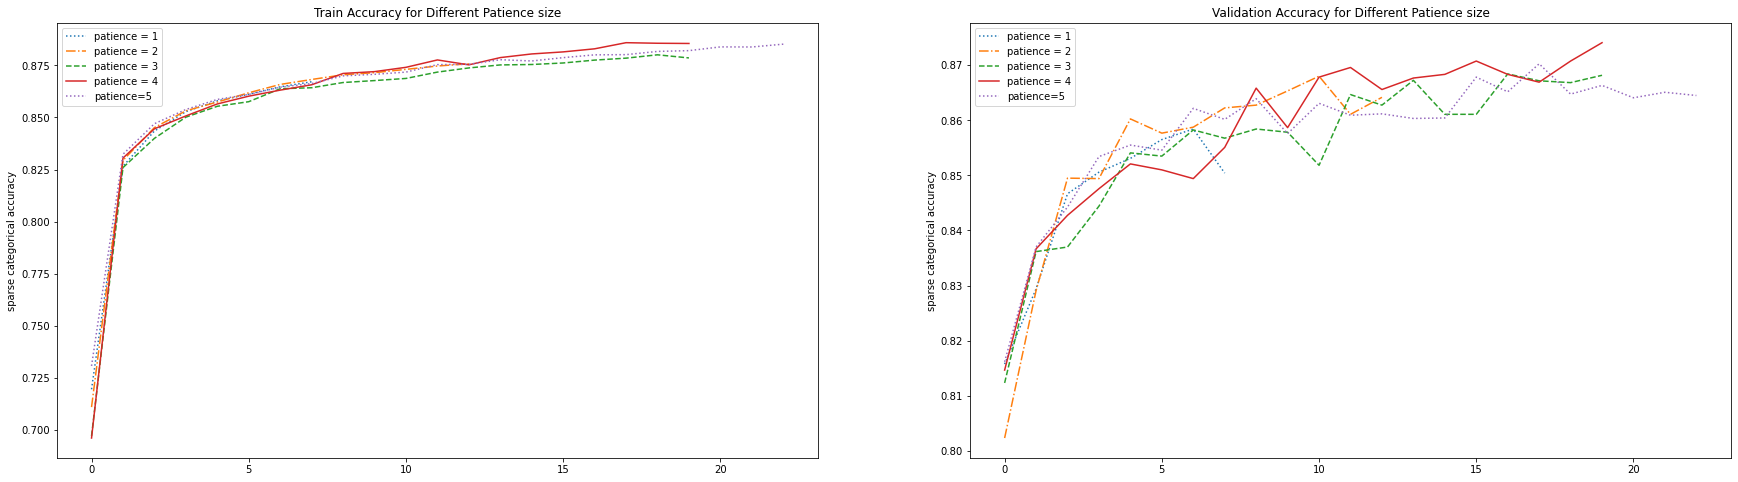

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure(figsize=(30,8))
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

plt.subplot(1, 2, 1)

for i in range(5):
    plt.plot(output_list_e[i].history['sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Train Accuracy for Different Patience size')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])


plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(output_list_e[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Validation Accuracy for Different Patience size')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1]) 
plt.show();

plt.savefig('patience.png');

In [14]:
loss = np.zeros(5)
accuracy= np.zeros(5)
for i in range(5):
  loss[i], accuracy[i] = e_model[i].evaluate(fx_test, fy_test)

313/313 [==============================] - 0s 837us/step - loss: 0.4135 - sparse_categorical_accuracy: 0.8543


In [15]:
display(Markdown(f"Different patience levels give a test accuracy centered around {np.mean(accuracy) :.3f}"),
        Markdown(f"The minimum is {min(accuracy):.4f} and the maximum is {max(accuracy) :.4f}"))

Different patience levels give a test accuracy centered around 0.855

The minimum is 0.8428 and the maximum is 0.8650

Patience = 4 seems best for this dataset: implement `tf.keras.callbacks.Earlystopping(patience= 4)` for all further steps



In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

### Complex Models Network Architecture

Network 1: [Input Layer, Hidden Layer 1, Hidden Layer 4, Output Layer]

Network 2: [Input Layer, Hidden Layer 1, Hidden Layer 2, Hidden Layer 4, Output Layer]

Network 3: [Input Layer, Hidden Layer 1, Hidden Layer 2, Hidden Layer 3, Hidden Layer 4, Output Layer]

For each network, we will test 3 different learning rates, 3 different filter sizes, and 3 different Dense layer unit size -- 3\*3\*3\*3 = 81 model comparisons in total
- learning rates: [Adam(0.01), Adam(0.001), Adam(0.0001)]
- filter sizes: [16, 24, 32]
- dense layer unit sizes: [64, 128, 256]

#### Model 1

**Build and Train 9 Complex Model 1s**

- use early stop call back: it seems that the model was overfitting in baseline model with all training 100 epochs
- implement validation split 0.2

In [17]:
nets= 3*3

filter= [16, 24, 32]
dense= [64, 128, 256]

In [18]:
# we will add conv layers incrementally with a Dense layer
# create a for loop to try different parameters

### 1 HIDDEN CONV2D LAYER ###

c_model1 = [0]*nets
history1 = [0]*nets
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)

start_full = time.time()

i = 0
for j in range(3):
  for k in range(3):
    c_model1[i] = tf.keras.Sequential()
    c_model1[i].add(tf.keras.layers.Conv2D(filter[j],kernel_size=5,padding='same',activation='relu',
            input_shape=(28,28,1)))
    
    c_model1[i].add(tf.keras.layers.Flatten())
    c_model1[i].add(tf.keras.layers.Dense(dense[k], activation='relu'))
    c_model1[i].add(tf.keras.layers.Dense(10, activation='softmax'))
    
    c_model1[i].compile(optimizer= tf.keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

    start = time.time()
    history1[i] =  c_model1[i].fit(fx_train, fy_train, validation_split= 0.2,  epochs=100, batch_size=128, callbacks = [early_stop])
    end = time.time()
    display(Markdown(f"**Training time for {len(history1[i].epoch)} epochs**: {(end-start): .3f}s"))

    i += 1

end_full = time.time()

Epoch 1/100
375/375 [==============================] - 6s 16ms/step - loss: 0.4767 - sparse_categorical_accuracy: 0.8325 - val_loss: 0.3576 - val_sparse_categorical_accuracy: 0.8769
Epoch 2/100
375/375 [==============================] - 6s 16ms/step - loss: 0.3182 - sparse_categorical_accuracy: 0.8862 - val_loss: 0.3198 - val_sparse_categorical_accuracy: 0.8855
Epoch 3/100
375/375 [==============================] - 6s 16ms/step - loss: 0.2766 - sparse_categorical_accuracy: 0.8998 - val_loss: 0.3000 - val_sparse_categorical_accuracy: 0.8923
Epoch 4/100
375/375 [==============================] - 6s 16ms/step - loss: 0.2427 - sparse_categorical_accuracy: 0.9114 - val_loss: 0.2910 - val_sparse_categorical_accuracy: 0.8933
Epoch 5/100
375/375 [==============================] - 6s 16ms/step - loss: 0.2157 - sparse_categorical_accuracy: 0.9218 - val_loss: 0.2794 - val_sparse_categorical_accuracy: 0.9003
Epoch 6/100
375/375 [==============================] - 6s 16ms/step - loss: 0.1929 - spars

**Training time for 10 epochs**:  59.754s

Epoch 1/100
375/375 [==============================] - 7s 18ms/step - loss: 0.4576 - sparse_categorical_accuracy: 0.8415 - val_loss: 0.3444 - val_sparse_categorical_accuracy: 0.8752
Epoch 2/100
375/375 [==============================] - 7s 18ms/step - loss: 0.2982 - sparse_categorical_accuracy: 0.8926 - val_loss: 0.2925 - val_sparse_categorical_accuracy: 0.8945
Epoch 3/100
375/375 [==============================] - 7s 18ms/step - loss: 0.2489 - sparse_categorical_accuracy: 0.9096 - val_loss: 0.2985 - val_sparse_categorical_accuracy: 0.8934
Epoch 4/100
375/375 [==============================] - 7s 18ms/step - loss: 0.2149 - sparse_categorical_accuracy: 0.9207 - val_loss: 0.2718 - val_sparse_categorical_accuracy: 0.9051
Epoch 5/100
375/375 [==============================] - 7s 18ms/step - loss: 0.1902 - sparse_categorical_accuracy: 0.9315 - val_loss: 0.2756 - val_sparse_categorical_accuracy: 0.8986
Epoch 6/100
375/375 [==============================] - 7s 18ms/step - loss: 0.1659 - spars

**Training time for 10 epochs**:  67.725s

Epoch 1/100
375/375 [==============================] - 10s 25ms/step - loss: 0.4279 - sparse_categorical_accuracy: 0.8479 - val_loss: 0.3260 - val_sparse_categorical_accuracy: 0.8822
Epoch 2/100
375/375 [==============================] - 9s 24ms/step - loss: 0.2745 - sparse_categorical_accuracy: 0.9015 - val_loss: 0.2989 - val_sparse_categorical_accuracy: 0.8925
Epoch 3/100
375/375 [==============================] - 9s 24ms/step - loss: 0.2284 - sparse_categorical_accuracy: 0.9168 - val_loss: 0.2900 - val_sparse_categorical_accuracy: 0.8922
Epoch 4/100
375/375 [==============================] - 9s 24ms/step - loss: 0.1907 - sparse_categorical_accuracy: 0.9295 - val_loss: 0.2645 - val_sparse_categorical_accuracy: 0.9040
Epoch 5/100
375/375 [==============================] - 9s 24ms/step - loss: 0.1575 - sparse_categorical_accuracy: 0.9428 - val_loss: 0.2760 - val_sparse_categorical_accuracy: 0.9067
Epoch 6/100
375/375 [==============================] - 9s 24ms/step - loss: 0.1319 - spar

**Training time for 7 epochs**:  63.435s

Epoch 1/100
375/375 [==============================] - 8s 19ms/step - loss: 0.4683 - sparse_categorical_accuracy: 0.8358 - val_loss: 0.3735 - val_sparse_categorical_accuracy: 0.8657
Epoch 2/100
375/375 [==============================] - 7s 19ms/step - loss: 0.3042 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.2980 - val_sparse_categorical_accuracy: 0.8929
Epoch 3/100
375/375 [==============================] - 7s 19ms/step - loss: 0.2548 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.2806 - val_sparse_categorical_accuracy: 0.8983
Epoch 4/100
375/375 [==============================] - 7s 19ms/step - loss: 0.2241 - sparse_categorical_accuracy: 0.9178 - val_loss: 0.2729 - val_sparse_categorical_accuracy: 0.9019
Epoch 5/100
375/375 [==============================] - 7s 19ms/step - loss: 0.2003 - sparse_categorical_accuracy: 0.9275 - val_loss: 0.2735 - val_sparse_categorical_accuracy: 0.9040
Epoch 6/100
375/375 [==============================] - 7s 19ms/step - loss: 0.1756 - spars

**Training time for 11 epochs**:  78.718s

Epoch 1/100
375/375 [==============================] - 9s 23ms/step - loss: 0.4240 - sparse_categorical_accuracy: 0.8494 - val_loss: 0.3188 - val_sparse_categorical_accuracy: 0.8863
Epoch 2/100
375/375 [==============================] - 9s 23ms/step - loss: 0.2811 - sparse_categorical_accuracy: 0.8981 - val_loss: 0.3031 - val_sparse_categorical_accuracy: 0.8913
Epoch 3/100
375/375 [==============================] - 9s 23ms/step - loss: 0.2311 - sparse_categorical_accuracy: 0.9147 - val_loss: 0.2774 - val_sparse_categorical_accuracy: 0.9007
Epoch 4/100
375/375 [==============================] - 9s 23ms/step - loss: 0.1966 - sparse_categorical_accuracy: 0.9277 - val_loss: 0.2857 - val_sparse_categorical_accuracy: 0.8998
Epoch 5/100
375/375 [==============================] - 9s 23ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.9388 - val_loss: 0.2702 - val_sparse_categorical_accuracy: 0.9053
Epoch 6/100
375/375 [==============================] - 9s 23ms/step - loss: 0.1438 - spars

**Training time for 8 epochs**:  69.369s

Epoch 1/100
375/375 [==============================] - 13s 33ms/step - loss: 0.4104 - sparse_categorical_accuracy: 0.8530 - val_loss: 0.3176 - val_sparse_categorical_accuracy: 0.8837
Epoch 2/100
375/375 [==============================] - 12s 32ms/step - loss: 0.2681 - sparse_categorical_accuracy: 0.9028 - val_loss: 0.2796 - val_sparse_categorical_accuracy: 0.8986
Epoch 3/100
375/375 [==============================] - 12s 32ms/step - loss: 0.2110 - sparse_categorical_accuracy: 0.9226 - val_loss: 0.2753 - val_sparse_categorical_accuracy: 0.9015
Epoch 4/100
375/375 [==============================] - 12s 32ms/step - loss: 0.1721 - sparse_categorical_accuracy: 0.9361 - val_loss: 0.2646 - val_sparse_categorical_accuracy: 0.9063
Epoch 5/100
375/375 [==============================] - 12s 32ms/step - loss: 0.1386 - sparse_categorical_accuracy: 0.9493 - val_loss: 0.2633 - val_sparse_categorical_accuracy: 0.9097
Epoch 6/100
375/375 [==============================] - 12s 31ms/step - loss: 0.1099 -

**Training time for 8 epochs**:  95.455s

Epoch 1/100
375/375 [==============================] - 9s 22ms/step - loss: 0.4383 - sparse_categorical_accuracy: 0.8452 - val_loss: 0.3323 - val_sparse_categorical_accuracy: 0.8805
Epoch 2/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2840 - sparse_categorical_accuracy: 0.8971 - val_loss: 0.2820 - val_sparse_categorical_accuracy: 0.8978
Epoch 3/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2378 - sparse_categorical_accuracy: 0.9133 - val_loss: 0.2713 - val_sparse_categorical_accuracy: 0.9018
Epoch 4/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2026 - sparse_categorical_accuracy: 0.9252 - val_loss: 0.2725 - val_sparse_categorical_accuracy: 0.9021
Epoch 5/100
375/375 [==============================] - 8s 22ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.9354 - val_loss: 0.2664 - val_sparse_categorical_accuracy: 0.9044
Epoch 6/100
375/375 [==============================] - 8s 22ms/step - loss: 0.1534 - spars

**Training time for 8 epochs**:  66.451s

Epoch 1/100
375/375 [==============================] - 11s 28ms/step - loss: 0.4237 - sparse_categorical_accuracy: 0.8508 - val_loss: 0.3213 - val_sparse_categorical_accuracy: 0.8862
Epoch 2/100
375/375 [==============================] - 10s 27ms/step - loss: 0.2786 - sparse_categorical_accuracy: 0.8994 - val_loss: 0.3011 - val_sparse_categorical_accuracy: 0.8898
Epoch 3/100
375/375 [==============================] - 10s 27ms/step - loss: 0.2236 - sparse_categorical_accuracy: 0.9183 - val_loss: 0.2789 - val_sparse_categorical_accuracy: 0.8975
Epoch 4/100
375/375 [==============================] - 10s 27ms/step - loss: 0.1889 - sparse_categorical_accuracy: 0.9311 - val_loss: 0.2648 - val_sparse_categorical_accuracy: 0.9061
Epoch 5/100
375/375 [==============================] - 10s 27ms/step - loss: 0.1580 - sparse_categorical_accuracy: 0.9427 - val_loss: 0.2786 - val_sparse_categorical_accuracy: 0.9084
Epoch 6/100
375/375 [==============================] - 10s 28ms/step - loss: 0.1303 -

**Training time for 7 epochs**:  71.984s

Epoch 1/100
375/375 [==============================] - 16s 41ms/step - loss: 0.4229 - sparse_categorical_accuracy: 0.8511 - val_loss: 0.3240 - val_sparse_categorical_accuracy: 0.8838
Epoch 2/100
375/375 [==============================] - 15s 41ms/step - loss: 0.2736 - sparse_categorical_accuracy: 0.9002 - val_loss: 0.2825 - val_sparse_categorical_accuracy: 0.8988
Epoch 3/100
375/375 [==============================] - 15s 40ms/step - loss: 0.2160 - sparse_categorical_accuracy: 0.9203 - val_loss: 0.2794 - val_sparse_categorical_accuracy: 0.8985
Epoch 4/100
375/375 [==============================] - 15s 40ms/step - loss: 0.1788 - sparse_categorical_accuracy: 0.9342 - val_loss: 0.2727 - val_sparse_categorical_accuracy: 0.9030
Epoch 5/100
375/375 [==============================] - 15s 40ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.9463 - val_loss: 0.2775 - val_sparse_categorical_accuracy: 0.9074
Epoch 6/100
375/375 [==============================] - 15s 41ms/step - loss: 0.1165 -

**Training time for 7 epochs**:  107.028s

In [19]:
display(Markdown(f"**Total training time for 9 Model 1s**: {(end_full-start_full): .3f}s"))

**Total training time for 9 Model 1s**:  680.439s

In [21]:
i = 0
t_epochs = np.zeros(9)
for j in range(3):
  for k in range(3):
    t_epochs[i] = len(history1[i].epoch)
    display(Markdown(f"**Model1_{i} parameters:** {filter[j]} filters, {dense[k]} dense units"),
            Markdown(f"For Model1_{i}, it took {t_epochs[i]} epochs to converge "))
    i +=1

display(Markdown(f"The shortest was {min(t_epochs)} and the longest was {max(t_epochs)} for Model 1"))

**Model1_0 parameters:** 16 filters, 64 dense units

For Model1_0, it took 10.0 epochs to converge 

**Model1_1 parameters:** 16 filters, 128 dense units

For Model1_1, it took 10.0 epochs to converge 

**Model1_2 parameters:** 16 filters, 256 dense units

For Model1_2, it took 7.0 epochs to converge 

**Model1_3 parameters:** 24 filters, 64 dense units

For Model1_3, it took 11.0 epochs to converge 

**Model1_4 parameters:** 24 filters, 128 dense units

For Model1_4, it took 8.0 epochs to converge 

**Model1_5 parameters:** 24 filters, 256 dense units

For Model1_5, it took 8.0 epochs to converge 

**Model1_6 parameters:** 32 filters, 64 dense units

For Model1_6, it took 8.0 epochs to converge 

**Model1_7 parameters:** 32 filters, 128 dense units

For Model1_7, it took 7.0 epochs to converge 

**Model1_8 parameters:** 32 filters, 256 dense units

For Model1_8, it took 7.0 epochs to converge 

The shortest was 7.0 and the longest was 11.0 for Model 1

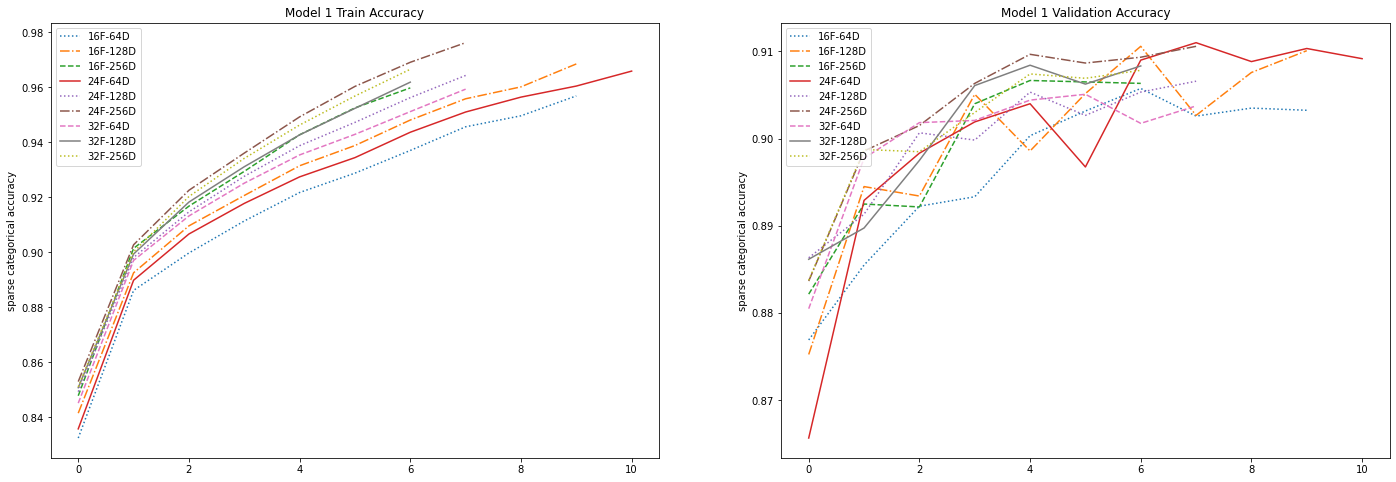

<Figure size 432x288 with 0 Axes>

In [46]:
names = ["16F-64D", "16F-128D", "16F-256D",
         "24F-64D", "24F-128D", "24F-256D",
         "32F-64D", "32F-128D", "32F-256D"]


plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
for i in range(nets):
    plt.plot(history1[i].history['sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Model 1 Train Accuracy')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.subplot(1,2,2)
for i in range(nets):
    plt.plot(history1[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Model 1 Validation Accuracy')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])


plt.show();
plt.savefig('model1.png')

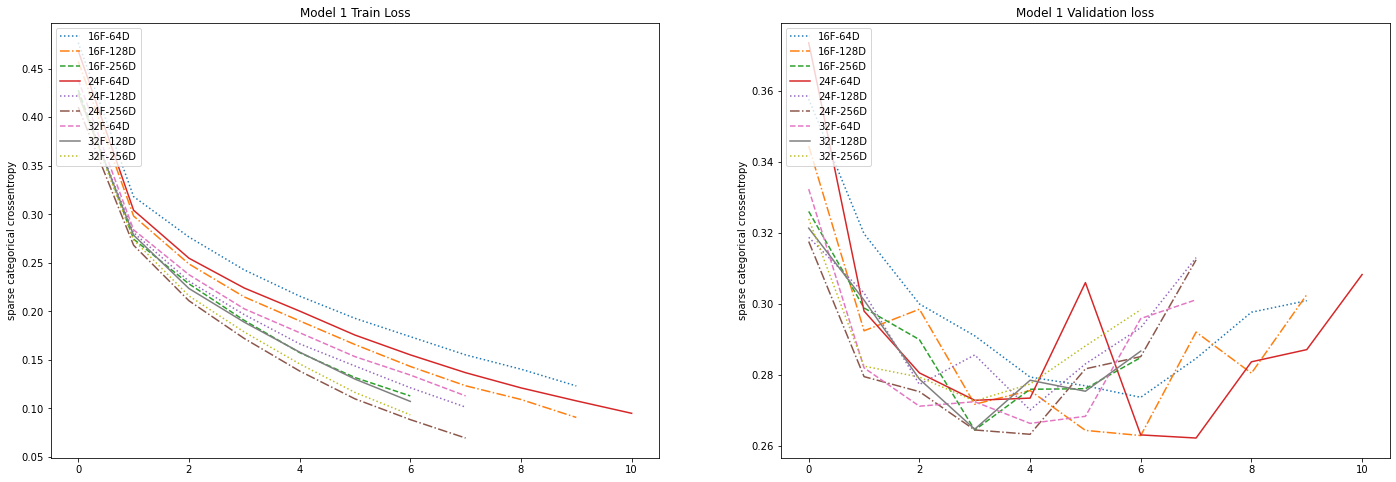

<Figure size 432x288 with 0 Axes>

In [47]:
plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
for i in range(nets):
    plt.plot(history1[i].history['loss'],linestyle=styles[i])

plt.title('Model 1 Train Loss')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.1,0.5])

plt.subplot(1,2,2)
for i in range(nets):
    plt.plot(history1[i].history['val_loss'],linestyle=styles[i])

plt.title('Model 1 Validation loss')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.1,0.5])


plt.show();
plt.savefig('model1_loss.png')

**Evaluate Model 1s**

In [26]:
loss1 = np.zeros(9)
accuracy1= np.zeros(9)
for i in range(9):
  loss1[i], accuracy1[i] = c_model1[i].evaluate(fx_test,fy_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.3078 - sparse_categorical_accuracy: 0.9040


In [32]:
display(Markdown(f"This 1 CONV2D layer architecture gives a test accuracy centered around {np.mean(accuracy1) :.3f}"),
        Markdown(f"The minimum is {min(accuracy1):.4f} and the maximum is {max(accuracy1) :.4f}"))

This 1 CONV2D layer architecture gives a test accuracy centered around 0.903

The minimum is 0.9003 and the maximum is 0.9067

***24-128***

**Build and train Model 2s**

In [33]:
### 2 HIDDEN CONV2D LAYERS ###
c_model2 = [0]*nets
history2 = [0]* nets

start_full2 = time.time()

i = 0 
for j in range(3):
  for k in range(3):
      c_model2[i] = tf.keras.Sequential()
      c_model2[i].add(tf.keras.layers.Conv2D(filter[j],kernel_size=5,padding='same',activation='relu',
              input_shape=(28,28,1)))
      c_model2[i].add(tf.keras.layers.Conv2D(filter[j],kernel_size=5,padding='same',activation='relu'))
      
      c_model2[i].add(tf.keras.layers.Flatten())
      c_model2[i].add(tf.keras.layers.Dense(dense[k], activation='relu'))
      c_model2[i].add(tf.keras.layers.Dense(10, activation='softmax'))

      c_model2[i].compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
        
      start = time.time()
      history2[i] =  c_model2[i].fit(fx_train, fy_train, validation_split= 0.2,  epochs=100, batch_size=128, callbacks = [early_stop])
      end = time.time()
      display(Markdown(f"**Training time for {len(history2[i].epoch)} epochs**: {(end-start): .3f}s"))

      i += 1

end_full2 = time.time()

Epoch 1/100
375/375 [==============================] - 26s 67ms/step - loss: 0.4736 - sparse_categorical_accuracy: 0.8314 - val_loss: 0.3532 - val_sparse_categorical_accuracy: 0.8733
Epoch 2/100
375/375 [==============================] - 25s 67ms/step - loss: 0.3017 - sparse_categorical_accuracy: 0.8903 - val_loss: 0.2927 - val_sparse_categorical_accuracy: 0.8940
Epoch 3/100
375/375 [==============================] - 25s 68ms/step - loss: 0.2499 - sparse_categorical_accuracy: 0.9080 - val_loss: 0.2861 - val_sparse_categorical_accuracy: 0.8951
Epoch 4/100
375/375 [==============================] - 25s 67ms/step - loss: 0.2212 - sparse_categorical_accuracy: 0.9191 - val_loss: 0.2610 - val_sparse_categorical_accuracy: 0.9036
Epoch 5/100
375/375 [==============================] - 25s 66ms/step - loss: 0.1893 - sparse_categorical_accuracy: 0.9296 - val_loss: 0.2596 - val_sparse_categorical_accuracy: 0.9056
Epoch 6/100
375/375 [==============================] - 25s 66ms/step - loss: 0.1612 -

**Training time for 9 epochs**:  224.971s

Epoch 1/100
375/375 [==============================] - 26s 69ms/step - loss: 0.4486 - sparse_categorical_accuracy: 0.8419 - val_loss: 0.3681 - val_sparse_categorical_accuracy: 0.8698
Epoch 2/100
375/375 [==============================] - 26s 68ms/step - loss: 0.2911 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.2922 - val_sparse_categorical_accuracy: 0.8962
Epoch 3/100
375/375 [==============================] - 26s 68ms/step - loss: 0.2393 - sparse_categorical_accuracy: 0.9121 - val_loss: 0.2682 - val_sparse_categorical_accuracy: 0.9028
Epoch 4/100
375/375 [==============================] - 26s 69ms/step - loss: 0.2054 - sparse_categorical_accuracy: 0.9240 - val_loss: 0.2860 - val_sparse_categorical_accuracy: 0.9001
Epoch 5/100
375/375 [==============================] - 26s 69ms/step - loss: 0.1717 - sparse_categorical_accuracy: 0.9371 - val_loss: 0.2548 - val_sparse_categorical_accuracy: 0.9110
Epoch 6/100
375/375 [==============================] - 26s 68ms/step - loss: 0.1393 -

**Training time for 8 epochs**:  205.806s

Epoch 1/100
375/375 [==============================] - 29s 78ms/step - loss: 0.4451 - sparse_categorical_accuracy: 0.8431 - val_loss: 0.3301 - val_sparse_categorical_accuracy: 0.8812
Epoch 2/100
375/375 [==============================] - 29s 79ms/step - loss: 0.2784 - sparse_categorical_accuracy: 0.8993 - val_loss: 0.2789 - val_sparse_categorical_accuracy: 0.8961
Epoch 3/100
375/375 [==============================] - 30s 79ms/step - loss: 0.2212 - sparse_categorical_accuracy: 0.9179 - val_loss: 0.2627 - val_sparse_categorical_accuracy: 0.9041
Epoch 4/100
375/375 [==============================] - 29s 78ms/step - loss: 0.1760 - sparse_categorical_accuracy: 0.9353 - val_loss: 0.2455 - val_sparse_categorical_accuracy: 0.9137
Epoch 5/100
375/375 [==============================] - 30s 79ms/step - loss: 0.1405 - sparse_categorical_accuracy: 0.9482 - val_loss: 0.2562 - val_sparse_categorical_accuracy: 0.9107
Epoch 6/100
375/375 [==============================] - 29s 79ms/step - loss: 0.1059 -

**Training time for 7 epochs**:  206.597s

Epoch 1/100
375/375 [==============================] - 39s 104ms/step - loss: 0.4573 - sparse_categorical_accuracy: 0.8364 - val_loss: 0.3504 - val_sparse_categorical_accuracy: 0.8754
Epoch 2/100
375/375 [==============================] - 39s 105ms/step - loss: 0.2951 - sparse_categorical_accuracy: 0.8931 - val_loss: 0.2911 - val_sparse_categorical_accuracy: 0.8940
Epoch 3/100
375/375 [==============================] - 39s 104ms/step - loss: 0.2409 - sparse_categorical_accuracy: 0.9118 - val_loss: 0.2692 - val_sparse_categorical_accuracy: 0.9043
Epoch 4/100
375/375 [==============================] - 38s 103ms/step - loss: 0.1994 - sparse_categorical_accuracy: 0.9273 - val_loss: 0.2650 - val_sparse_categorical_accuracy: 0.9047
Epoch 5/100
375/375 [==============================] - 37s 98ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.9392 - val_loss: 0.2664 - val_sparse_categorical_accuracy: 0.9067
Epoch 6/100
375/375 [==============================] - 37s 98ms/step - loss: 0.13

**Training time for 9 epochs**:  340.655s

Epoch 1/100
375/375 [==============================] - 38s 100ms/step - loss: 0.4539 - sparse_categorical_accuracy: 0.8394 - val_loss: 0.3407 - val_sparse_categorical_accuracy: 0.8758
Epoch 2/100
375/375 [==============================] - 38s 100ms/step - loss: 0.2844 - sparse_categorical_accuracy: 0.8964 - val_loss: 0.2865 - val_sparse_categorical_accuracy: 0.8945
Epoch 3/100
375/375 [==============================] - 38s 100ms/step - loss: 0.2257 - sparse_categorical_accuracy: 0.9176 - val_loss: 0.2588 - val_sparse_categorical_accuracy: 0.9028
Epoch 4/100
375/375 [==============================] - 38s 100ms/step - loss: 0.1778 - sparse_categorical_accuracy: 0.9350 - val_loss: 0.2594 - val_sparse_categorical_accuracy: 0.9084
Epoch 5/100
375/375 [==============================] - 38s 100ms/step - loss: 0.1425 - sparse_categorical_accuracy: 0.9479 - val_loss: 0.2687 - val_sparse_categorical_accuracy: 0.9096
Epoch 6/100
375/375 [==============================] - 38s 101ms/step - loss: 0.

**Training time for 6 epochs**:  226.175s

Epoch 1/100
375/375 [==============================] - 42s 113ms/step - loss: 0.4339 - sparse_categorical_accuracy: 0.8475 - val_loss: 0.3108 - val_sparse_categorical_accuracy: 0.8914
Epoch 2/100
375/375 [==============================] - 43s 115ms/step - loss: 0.2650 - sparse_categorical_accuracy: 0.9027 - val_loss: 0.2634 - val_sparse_categorical_accuracy: 0.8990
Epoch 3/100
375/375 [==============================] - 43s 115ms/step - loss: 0.2102 - sparse_categorical_accuracy: 0.9231 - val_loss: 0.2416 - val_sparse_categorical_accuracy: 0.9126
Epoch 4/100
375/375 [==============================] - 43s 115ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.9394 - val_loss: 0.2488 - val_sparse_categorical_accuracy: 0.9123
Epoch 5/100
375/375 [==============================] - 44s 117ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.9536 - val_loss: 0.2580 - val_sparse_categorical_accuracy: 0.9154
Epoch 6/100
375/375 [==============================] - 43s 115ms/step - loss: 0.

**Training time for 6 epochs**:  258.614s

Epoch 1/100
375/375 [==============================] - 58s 154ms/step - loss: 0.4456 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.3374 - val_sparse_categorical_accuracy: 0.8788
Epoch 2/100
375/375 [==============================] - 58s 156ms/step - loss: 0.2846 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.2778 - val_sparse_categorical_accuracy: 0.8950
Epoch 3/100
375/375 [==============================] - 58s 155ms/step - loss: 0.2310 - sparse_categorical_accuracy: 0.9145 - val_loss: 0.2614 - val_sparse_categorical_accuracy: 0.9077
Epoch 4/100
375/375 [==============================] - 58s 156ms/step - loss: 0.1876 - sparse_categorical_accuracy: 0.9324 - val_loss: 0.2817 - val_sparse_categorical_accuracy: 0.9025
Epoch 5/100
375/375 [==============================] - 58s 155ms/step - loss: 0.1520 - sparse_categorical_accuracy: 0.9435 - val_loss: 0.2437 - val_sparse_categorical_accuracy: 0.9127
Epoch 6/100
375/375 [==============================] - 58s 155ms/step - loss: 0.

**Training time for 8 epochs**:  459.447s

Epoch 1/100
375/375 [==============================] - 61s 162ms/step - loss: 0.4335 - sparse_categorical_accuracy: 0.8451 - val_loss: 0.3122 - val_sparse_categorical_accuracy: 0.8898
Epoch 2/100
375/375 [==============================] - 60s 161ms/step - loss: 0.2712 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.2723 - val_sparse_categorical_accuracy: 0.9004
Epoch 3/100
375/375 [==============================] - 60s 161ms/step - loss: 0.2105 - sparse_categorical_accuracy: 0.9226 - val_loss: 0.2473 - val_sparse_categorical_accuracy: 0.9109
Epoch 4/100
375/375 [==============================] - 60s 161ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.9402 - val_loss: 0.2445 - val_sparse_categorical_accuracy: 0.9119
Epoch 5/100
375/375 [==============================] - 60s 160ms/step - loss: 0.1278 - sparse_categorical_accuracy: 0.9527 - val_loss: 0.2566 - val_sparse_categorical_accuracy: 0.9138
Epoch 6/100
375/375 [==============================] - 60s 159ms/step - loss: 0.

**Training time for 7 epochs**:  422.371s

Epoch 1/100
375/375 [==============================] - 66s 175ms/step - loss: 0.4076 - sparse_categorical_accuracy: 0.8537 - val_loss: 0.3223 - val_sparse_categorical_accuracy: 0.8782
Epoch 2/100
375/375 [==============================] - 65s 174ms/step - loss: 0.2516 - sparse_categorical_accuracy: 0.9081 - val_loss: 0.2510 - val_sparse_categorical_accuracy: 0.9091
Epoch 3/100
375/375 [==============================] - 65s 174ms/step - loss: 0.1937 - sparse_categorical_accuracy: 0.9285 - val_loss: 0.2604 - val_sparse_categorical_accuracy: 0.9065
Epoch 4/100
375/375 [==============================] - 66s 177ms/step - loss: 0.1488 - sparse_categorical_accuracy: 0.9451 - val_loss: 0.2537 - val_sparse_categorical_accuracy: 0.9127
Epoch 5/100
375/375 [==============================] - 65s 174ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.2521 - val_sparse_categorical_accuracy: 0.9167


**Training time for 5 epochs**:  327.673s

In [34]:
display(Markdown(f"**Total training time for 9 Model 2s**: {(end_full2-start_full2): .3f}s"))

**Total training time for 9 Model 2s**:  2672.733s

In [35]:
i = 0
t_epochs = np.zeros(9)
for j in range(3):
  for k in range(3):
    t_epochs[i] = len(history2[i].epoch)
    display(Markdown(f"**Model2_{i} parameters:** {filter[j]} filters, {dense[k]} dense units"),
            Markdown(f"For Model2_{i}, it took {t_epochs[i]} epochs to converge "))
    i +=1

display(Markdown(f"The shortest was {min(t_epochs)} and the longest was {max(t_epochs)} for Model 2"))


**Model2_0 parameters:** 16 filters, 64 dense units

For Model2_0, it took 9.0 epochs to converge 

**Model2_1 parameters:** 16 filters, 128 dense units

For Model2_1, it took 8.0 epochs to converge 

**Model2_2 parameters:** 16 filters, 256 dense units

For Model2_2, it took 7.0 epochs to converge 

**Model2_3 parameters:** 24 filters, 64 dense units

For Model2_3, it took 9.0 epochs to converge 

**Model2_4 parameters:** 24 filters, 128 dense units

For Model2_4, it took 6.0 epochs to converge 

**Model2_5 parameters:** 24 filters, 256 dense units

For Model2_5, it took 6.0 epochs to converge 

**Model2_6 parameters:** 32 filters, 64 dense units

For Model2_6, it took 8.0 epochs to converge 

**Model2_7 parameters:** 32 filters, 128 dense units

For Model2_7, it took 7.0 epochs to converge 

**Model2_8 parameters:** 32 filters, 256 dense units

For Model2_8, it took 5.0 epochs to converge 

The shortest was 5.0 and the longest was 9.0 for Model 2

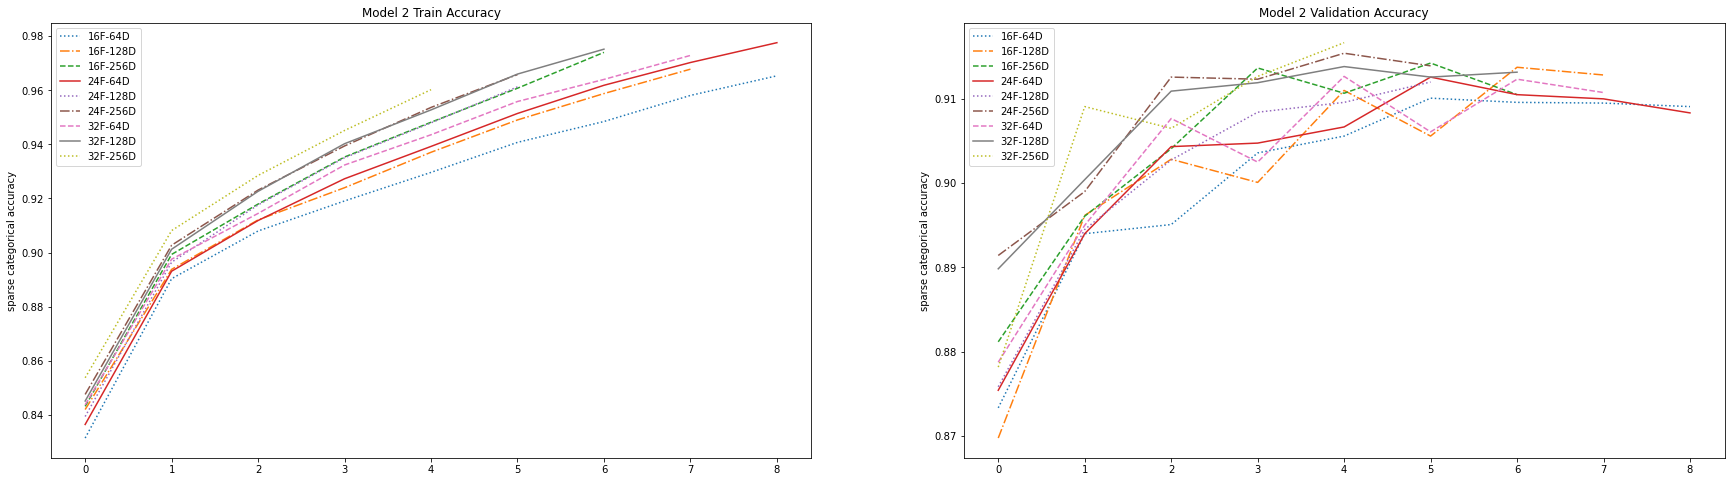

<Figure size 432x288 with 0 Axes>

In [48]:
plt.figure(figsize=(30,8))

plt.subplot(1,2,1)
for i in range(nets):
    plt.plot(history2[i].history['sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Model 2 Train Accuracy')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.subplot(1,2,2)
for i in range(nets):
    plt.plot(history2[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Model 2 Validation Accuracy')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.show();
plt.savefig('model2.png')

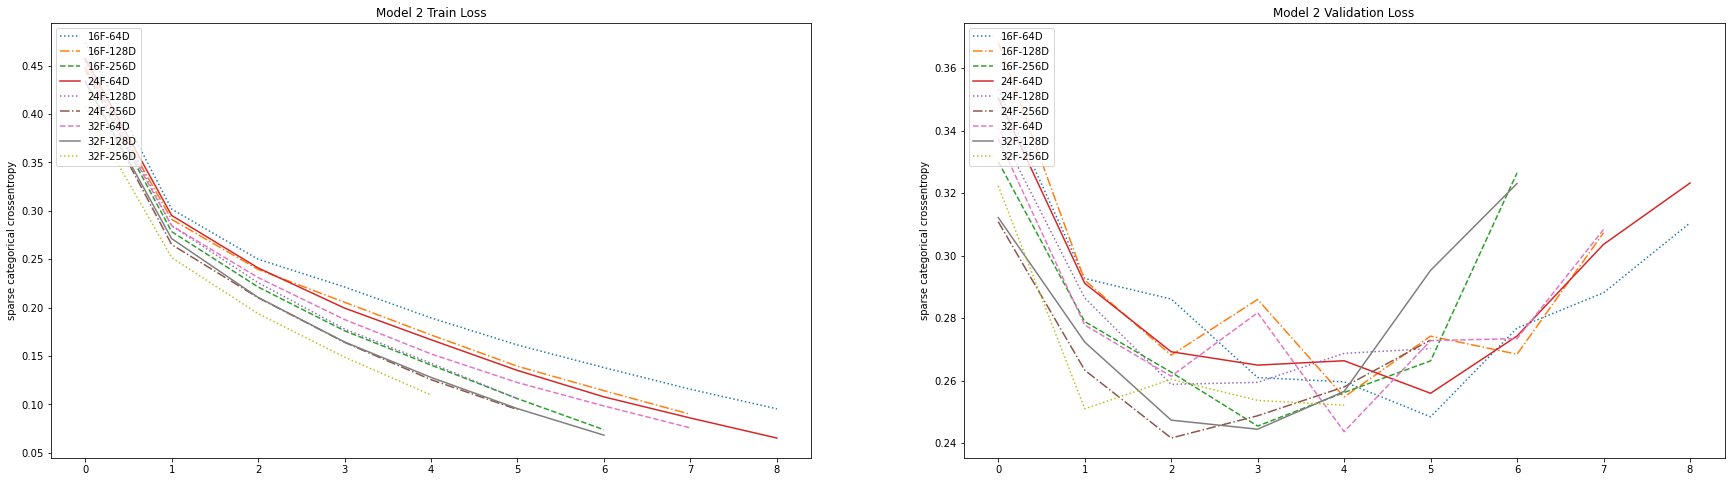

<Figure size 432x288 with 0 Axes>

In [49]:
plt.figure(figsize=(30,8))

plt.subplot(1,2,1)
for i in range(nets):
    plt.plot(history2[i].history['loss'],linestyle=styles[i])

plt.title('Model 2 Train Loss')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.subplot(1,2,2)
for i in range(nets):
    plt.plot(history2[i].history['val_loss'],linestyle=styles[i])

plt.title('Model 2 Validation Loss')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.show();
plt.savefig('model2_loss.png')

**Evaluate Model 2s**

In [38]:
loss2 = np.zeros(9)
accuracy2= np.zeros(9)
for i in range(9):
  loss2[i], accuracy2[i] = c_model2[i].evaluate(fx_test, fy_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.2686 - sparse_categorical_accuracy: 0.9140


In [39]:
display(Markdown(f"This 2 CONV2D layer architecture gives a test accuracy centered around {np.mean(accuracy2) :.3f}"),
        Markdown(f"The minimum is {min(accuracy2):.4f} and the maximum is {max(accuracy2) :.4f}"))

This 2 CONV2D layer architecture gives a test accuracy centered around 0.909

The minimum is 0.9055 and the maximum is 0.9140

***24-128***

**Build and Train Model 3s**

In [40]:
### 3 HIDDEN CONV2D LAYERS ###
c_model3 = [0]*nets
history3 = [0]*nets


start_full3= time.time()

i = 0
for j in range(3):
  for k in range(3):
      c_model3[i] = tf.keras.Sequential()
      c_model3[i].add(tf.keras.layers.Conv2D(filter[j],kernel_size=5,padding='same',activation='relu',
              input_shape=(28,28,1)))
      c_model3[i].add(tf.keras.layers.Conv2D(filter[j],kernel_size=5,padding='same',activation='relu'))
      c_model3[i].add(tf.keras.layers.Conv2D(filter[j],kernel_size=5,padding='same',activation='relu'))

      c_model3[i].add(tf.keras.layers.Flatten())
      c_model3[i].add(tf.keras.layers.Dense(dense[k], activation='relu'))
      c_model3[i].add(tf.keras.layers.Dense(10, activation='softmax'))

      c_model3[i].compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

      start = time.time()
      history3[i] =  c_model3[i].fit(fx_train, fy_train, validation_split= 0.2,  epochs=100, batch_size=128, callbacks = [early_stop])
      end = time.time()
      display(Markdown(f"**Training time for {len(history3[i].epoch)} epochs**: {(end-start): .3f}s"))

      i += 1
   
end_full3= time.time()

Epoch 1/100
375/375 [==============================] - 47s 123ms/step - loss: 0.4805 - sparse_categorical_accuracy: 0.8296 - val_loss: 0.3498 - val_sparse_categorical_accuracy: 0.8762
Epoch 2/100
375/375 [==============================] - 45s 120ms/step - loss: 0.2964 - sparse_categorical_accuracy: 0.8917 - val_loss: 0.2832 - val_sparse_categorical_accuracy: 0.8975
Epoch 3/100
375/375 [==============================] - 45s 119ms/step - loss: 0.2436 - sparse_categorical_accuracy: 0.9099 - val_loss: 0.2987 - val_sparse_categorical_accuracy: 0.8891
Epoch 4/100
375/375 [==============================] - 45s 119ms/step - loss: 0.2052 - sparse_categorical_accuracy: 0.9255 - val_loss: 0.2585 - val_sparse_categorical_accuracy: 0.9083
Epoch 5/100
375/375 [==============================] - 45s 119ms/step - loss: 0.1720 - sparse_categorical_accuracy: 0.9359 - val_loss: 0.2542 - val_sparse_categorical_accuracy: 0.9103
Epoch 6/100
375/375 [==============================] - 45s 119ms/step - loss: 0.

**Training time for 8 epochs**:  356.893s

Epoch 1/100
375/375 [==============================] - 46s 121ms/step - loss: 0.4555 - sparse_categorical_accuracy: 0.8359 - val_loss: 0.3468 - val_sparse_categorical_accuracy: 0.8732
Epoch 2/100
375/375 [==============================] - 46s 122ms/step - loss: 0.2831 - sparse_categorical_accuracy: 0.8969 - val_loss: 0.2717 - val_sparse_categorical_accuracy: 0.9011
Epoch 3/100
375/375 [==============================] - 46s 123ms/step - loss: 0.2264 - sparse_categorical_accuracy: 0.9173 - val_loss: 0.2510 - val_sparse_categorical_accuracy: 0.9071
Epoch 4/100
375/375 [==============================] - 46s 122ms/step - loss: 0.1865 - sparse_categorical_accuracy: 0.9307 - val_loss: 0.2389 - val_sparse_categorical_accuracy: 0.9133
Epoch 5/100
375/375 [==============================] - 46s 122ms/step - loss: 0.1503 - sparse_categorical_accuracy: 0.9452 - val_loss: 0.2522 - val_sparse_categorical_accuracy: 0.9115
Epoch 6/100
375/375 [==============================] - 46s 122ms/step - loss: 0.

**Training time for 7 epochs**:  320.366s

Epoch 1/100
375/375 [==============================] - 48s 127ms/step - loss: 0.4552 - sparse_categorical_accuracy: 0.8403 - val_loss: 0.3182 - val_sparse_categorical_accuracy: 0.8863
Epoch 2/100
375/375 [==============================] - 48s 127ms/step - loss: 0.2779 - sparse_categorical_accuracy: 0.8989 - val_loss: 0.2989 - val_sparse_categorical_accuracy: 0.8891
Epoch 3/100
375/375 [==============================] - 48s 128ms/step - loss: 0.2197 - sparse_categorical_accuracy: 0.9204 - val_loss: 0.2493 - val_sparse_categorical_accuracy: 0.9093
Epoch 4/100
375/375 [==============================] - 48s 128ms/step - loss: 0.1728 - sparse_categorical_accuracy: 0.9363 - val_loss: 0.2488 - val_sparse_categorical_accuracy: 0.9134
Epoch 5/100
375/375 [==============================] - 48s 127ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.9510 - val_loss: 0.2547 - val_sparse_categorical_accuracy: 0.9113
Epoch 6/100
375/375 [==============================] - 48s 128ms/step - loss: 0.

**Training time for 7 epochs**:  335.115s

Epoch 1/100
375/375 [==============================] - 69s 182ms/step - loss: 0.4598 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.3386 - val_sparse_categorical_accuracy: 0.8790
Epoch 2/100
375/375 [==============================] - 68s 182ms/step - loss: 0.2896 - sparse_categorical_accuracy: 0.8952 - val_loss: 0.2811 - val_sparse_categorical_accuracy: 0.8974
Epoch 3/100
375/375 [==============================] - 68s 182ms/step - loss: 0.2333 - sparse_categorical_accuracy: 0.9147 - val_loss: 0.2660 - val_sparse_categorical_accuracy: 0.9048
Epoch 4/100
375/375 [==============================] - 68s 182ms/step - loss: 0.1943 - sparse_categorical_accuracy: 0.9280 - val_loss: 0.2408 - val_sparse_categorical_accuracy: 0.9142
Epoch 5/100
375/375 [==============================] - 68s 181ms/step - loss: 0.1611 - sparse_categorical_accuracy: 0.9407 - val_loss: 0.2515 - val_sparse_categorical_accuracy: 0.9114
Epoch 6/100
375/375 [==============================] - 68s 182ms/step - loss: 0.

**Training time for 7 epochs**:  478.050s

Epoch 1/100
375/375 [==============================] - 68s 180ms/step - loss: 0.4628 - sparse_categorical_accuracy: 0.8340 - val_loss: 0.3254 - val_sparse_categorical_accuracy: 0.8808
Epoch 2/100
375/375 [==============================] - 67s 180ms/step - loss: 0.2781 - sparse_categorical_accuracy: 0.8990 - val_loss: 0.2777 - val_sparse_categorical_accuracy: 0.8967
Epoch 3/100
375/375 [==============================] - 67s 180ms/step - loss: 0.2194 - sparse_categorical_accuracy: 0.9201 - val_loss: 0.2574 - val_sparse_categorical_accuracy: 0.9056
Epoch 4/100
375/375 [==============================] - 67s 180ms/step - loss: 0.1769 - sparse_categorical_accuracy: 0.9353 - val_loss: 0.2341 - val_sparse_categorical_accuracy: 0.9153
Epoch 5/100
375/375 [==============================] - 68s 181ms/step - loss: 0.1355 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.2618 - val_sparse_categorical_accuracy: 0.9094
Epoch 6/100
375/375 [==============================] - 68s 181ms/step - loss: 0.

**Training time for 7 epochs**:  474.526s

Epoch 1/100
375/375 [==============================] - 70s 184ms/step - loss: 0.4565 - sparse_categorical_accuracy: 0.8387 - val_loss: 0.3386 - val_sparse_categorical_accuracy: 0.8756
Epoch 2/100
375/375 [==============================] - 69s 183ms/step - loss: 0.2794 - sparse_categorical_accuracy: 0.8976 - val_loss: 0.2691 - val_sparse_categorical_accuracy: 0.8985
Epoch 3/100
375/375 [==============================] - 69s 185ms/step - loss: 0.2202 - sparse_categorical_accuracy: 0.9184 - val_loss: 0.2469 - val_sparse_categorical_accuracy: 0.9105
Epoch 4/100
375/375 [==============================] - 69s 184ms/step - loss: 0.1758 - sparse_categorical_accuracy: 0.9351 - val_loss: 0.2429 - val_sparse_categorical_accuracy: 0.9104
Epoch 5/100
375/375 [==============================] - 69s 185ms/step - loss: 0.1366 - sparse_categorical_accuracy: 0.9493 - val_loss: 0.2484 - val_sparse_categorical_accuracy: 0.9151
Epoch 6/100
375/375 [==============================] - 69s 183ms/step - loss: 0.

**Training time for 7 epochs**:  483.429s

Epoch 1/100
375/375 [==============================] - 103s 275ms/step - loss: 0.4528 - sparse_categorical_accuracy: 0.8378 - val_loss: 0.3228 - val_sparse_categorical_accuracy: 0.8802
Epoch 2/100
375/375 [==============================] - 101s 268ms/step - loss: 0.2804 - sparse_categorical_accuracy: 0.8964 - val_loss: 0.2815 - val_sparse_categorical_accuracy: 0.8984
Epoch 3/100
375/375 [==============================] - 101s 269ms/step - loss: 0.2271 - sparse_categorical_accuracy: 0.9171 - val_loss: 0.2492 - val_sparse_categorical_accuracy: 0.9096
Epoch 4/100
375/375 [==============================] - 101s 270ms/step - loss: 0.1858 - sparse_categorical_accuracy: 0.9310 - val_loss: 0.2292 - val_sparse_categorical_accuracy: 0.9174
Epoch 5/100
375/375 [==============================] - 101s 270ms/step - loss: 0.1513 - sparse_categorical_accuracy: 0.9451 - val_loss: 0.2402 - val_sparse_categorical_accuracy: 0.9162
Epoch 6/100
375/375 [==============================] - 101s 269ms/step - lo

**Training time for 7 epochs**:  710.682s

Epoch 1/100
375/375 [==============================] - 106s 282ms/step - loss: 0.4288 - sparse_categorical_accuracy: 0.8471 - val_loss: 0.3190 - val_sparse_categorical_accuracy: 0.8822
Epoch 2/100
375/375 [==============================] - 106s 283ms/step - loss: 0.2652 - sparse_categorical_accuracy: 0.9023 - val_loss: 0.2679 - val_sparse_categorical_accuracy: 0.9042
Epoch 3/100
375/375 [==============================] - 106s 282ms/step - loss: 0.2090 - sparse_categorical_accuracy: 0.9234 - val_loss: 0.2498 - val_sparse_categorical_accuracy: 0.9080
Epoch 4/100
375/375 [==============================] - 106s 283ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.9400 - val_loss: 0.2429 - val_sparse_categorical_accuracy: 0.9147
Epoch 5/100
375/375 [==============================] - 106s 282ms/step - loss: 0.1281 - sparse_categorical_accuracy: 0.9532 - val_loss: 0.2555 - val_sparse_categorical_accuracy: 0.9137
Epoch 6/100
375/375 [==============================] - 105s 280ms/step - lo

**Training time for 7 epochs**:  740.035s

Epoch 1/100
375/375 [==============================] - 111s 294ms/step - loss: 0.4169 - sparse_categorical_accuracy: 0.8494 - val_loss: 0.3101 - val_sparse_categorical_accuracy: 0.8893
Epoch 2/100
375/375 [==============================] - 111s 295ms/step - loss: 0.2586 - sparse_categorical_accuracy: 0.9049 - val_loss: 0.2643 - val_sparse_categorical_accuracy: 0.9023
Epoch 3/100
375/375 [==============================] - 111s 296ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.9262 - val_loss: 0.2393 - val_sparse_categorical_accuracy: 0.9147
Epoch 4/100
375/375 [==============================] - 111s 295ms/step - loss: 0.1523 - sparse_categorical_accuracy: 0.9439 - val_loss: 0.2496 - val_sparse_categorical_accuracy: 0.9162
Epoch 5/100
375/375 [==============================] - 113s 300ms/step - loss: 0.1094 - sparse_categorical_accuracy: 0.9604 - val_loss: 0.2719 - val_sparse_categorical_accuracy: 0.9159
Epoch 6/100
375/375 [==============================] - 111s 296ms/step - lo

**Training time for 6 epochs**:  666.701s

In [41]:
display(Markdown(f"**Total training time for 9 Model 3s**: {(end_full3-start_full3): .3f}s"))

**Total training time for 9 Model 3s**:  4566.291s

In [43]:
i = 0
t_epochs = np.zeros(9)
for j in range(3):
  for k in range(3):
    t_epochs[i] = len(history3[i].epoch)
    display(Markdown(f"**Model3_{i} parameters:** {filter[j]} filters, {dense[k]} dense units"),
            Markdown(f"For Model3_{i}, it took {t_epochs[i]} epochs to converge "))
    i +=1

display(Markdown(f"The shortest was {min(t_epochs)} and the longest was {max(t_epochs)} for Model 3"))


**Model3_0 parameters:** 16 filters, 64 dense units

For Model3_0, it took 8.0 epochs to converge 

**Model3_1 parameters:** 16 filters, 128 dense units

For Model3_1, it took 7.0 epochs to converge 

**Model3_2 parameters:** 16 filters, 256 dense units

For Model3_2, it took 7.0 epochs to converge 

**Model3_3 parameters:** 24 filters, 64 dense units

For Model3_3, it took 7.0 epochs to converge 

**Model3_4 parameters:** 24 filters, 128 dense units

For Model3_4, it took 7.0 epochs to converge 

**Model3_5 parameters:** 24 filters, 256 dense units

For Model3_5, it took 7.0 epochs to converge 

**Model3_6 parameters:** 32 filters, 64 dense units

For Model3_6, it took 7.0 epochs to converge 

**Model3_7 parameters:** 32 filters, 128 dense units

For Model3_7, it took 7.0 epochs to converge 

**Model3_8 parameters:** 32 filters, 256 dense units

For Model3_8, it took 6.0 epochs to converge 

The shortest was 6.0 and the longest was 8.0 for Model 3

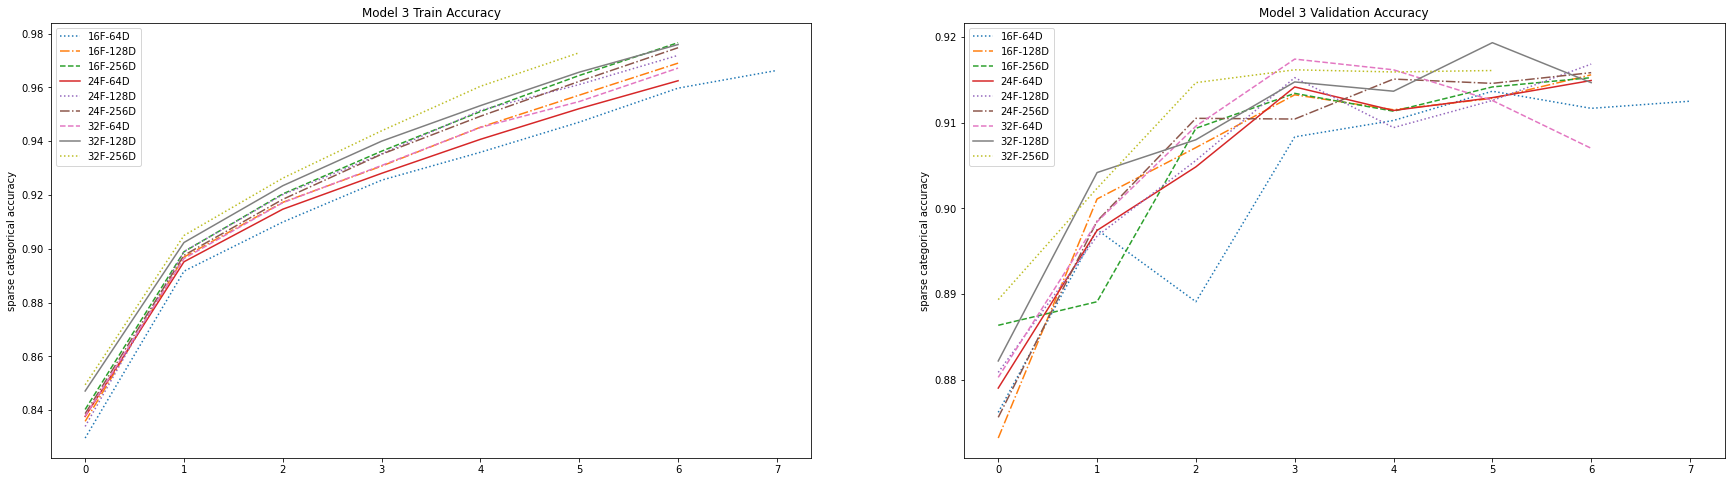

<Figure size 432x288 with 0 Axes>

In [50]:
plt.figure(figsize=(30,8))

plt.subplot(1,2,1)
for i in range(nets):
    plt.plot(history3[i].history['sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Model 3 Train Accuracy')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.subplot(1,2,2)
for i in range(nets):
    plt.plot(history3[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Model 3 Validation Accuracy')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.show();
plt.savefig('model3.png');

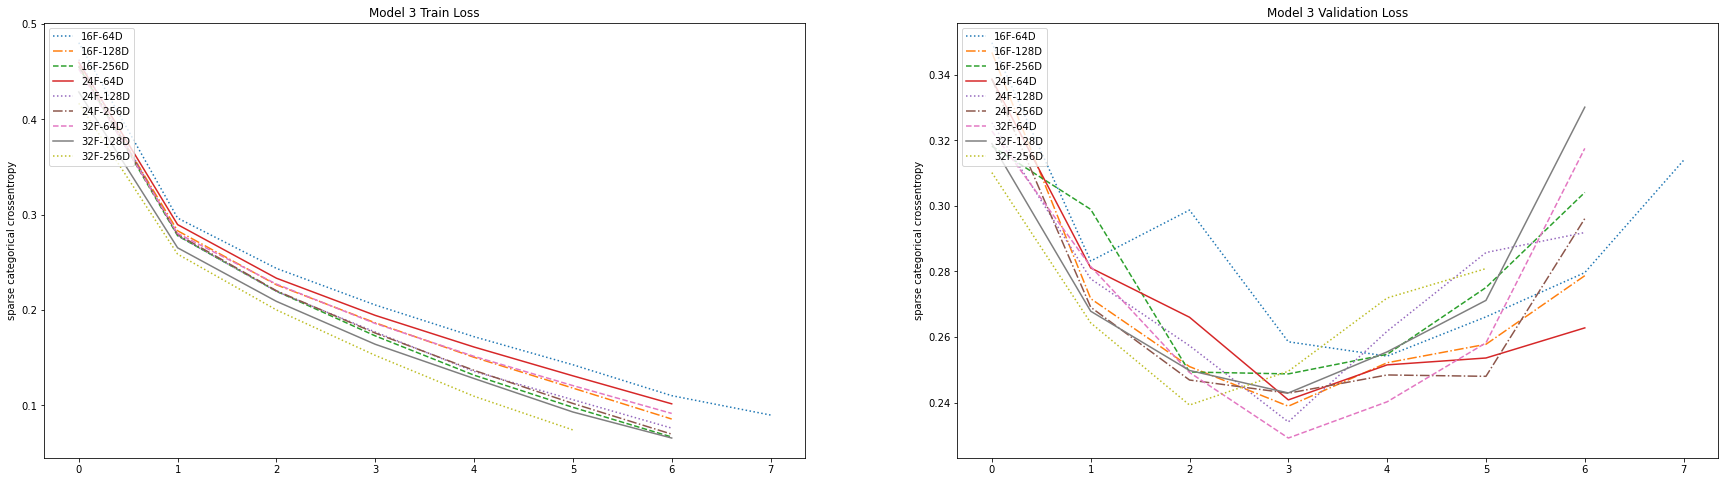

<Figure size 432x288 with 0 Axes>

In [51]:
plt.figure(figsize=(30,8))

plt.subplot(1,2,1)
for i in range(nets):
    plt.plot(history3[i].history['loss'],linestyle=styles[i])

plt.title('Model 3 Train Loss')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.subplot(1,2,2)
for i in range(nets):
    plt.plot(history3[i].history['val_loss'],linestyle=styles[i])

plt.title('Model 3 Validation Loss')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.show();
plt.savefig('model3_loss.png')

**Evaluate Model 3s**

In [52]:
loss3 = np.zeros(9)
accuracy3 = np.zeros(9)
for i in range(9):
  loss3[i], accuracy3[i] = c_model3[i].evaluate(fx_test, fy_test)

313/313 [==============================] - 4s 12ms/step - loss: 0.2993 - sparse_categorical_accuracy: 0.9145


In [53]:
display(Markdown(f"This 3 CONV2D layer architecture gives a test accuracy centered around {np.mean(accuracy3) :.3f}"),
        Markdown(f"The minimum is {min(accuracy3):.4f} and the maximum is {max(accuracy3) :.4f}"))

This 3 CONV2D layer architecture gives a test accuracy centered around 0.911

The minimum is 0.9007 and the maximum is 0.9153

Just like in the MNIST data, after training 27 different models, we are going to select a single model for further steps so it would save computation time by a lot. 

We took the training time, validation accuracy and loss to determine which parameters to use.
Overall, among the 3 model architectures 3 layers is slightly better than 2 layers. However, considering computational cost, having 2 layers is more reasonable than having 3 layers since it takes nearly double the time to train.

For 9 Model 3s, the training time was about 4566s while 2673s for 9 Model 2s.
So we select 2 hidden convolution layers as our network architecture.

Among the 9 filter and dense unit size combinations in Model 2, 24 feature maps and 256 dense units seem to be the best, which is the same as for the previous dataset.

### Regularization: Drop Out Rate

In [54]:
from gc import callbacks
#INTIALIZATION of dropout percentage
nets = 6
d_model = [0]*nets
output_list_d = []

start_full_d = time.time()

for j in range(6):
    d_model[j] = tf.keras.models.Sequential()
    d_model[j].add(tf.keras.layers.Conv2D(24,kernel_size=5,padding='same',activation='relu',
              input_shape=(28,28,1)))
    d_model[j].add(tf.keras.layers.Dropout(j*0.1))

    d_model[j].add(tf.keras.layers.Conv2D(24,kernel_size=5,padding='same',activation='relu'))
    d_model[j].add(tf.keras.layers.Dropout(j*0.1))

    d_model[j].add(tf.keras.layers.Flatten())
    d_model[j].add(tf.keras.layers.Dense(256, activation='relu'))
    d_model[j].add(tf.keras.layers.Dropout(j*0.1))

    d_model[j].add(tf.keras.layers.Dense(10, activation='softmax'))

    d_model[j].compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

    start = time.time()
    output_list_d.append(d_model[j].fit(fx_train, fy_train, epochs=100, batch_size=128, validation_split = 0.2, callbacks = [early_stop]))
    end = time.time()

    display(Markdown(f"**Training time for {len(output_list_d[j].epoch)} epochs**: {(end-start): .3f}s"))

end_full_d = time.time()

Epoch 1/100
375/375 [==============================] - 45s 120ms/step - loss: 0.4240 - sparse_categorical_accuracy: 0.8504 - val_loss: 0.3299 - val_sparse_categorical_accuracy: 0.8792
Epoch 2/100
375/375 [==============================] - 45s 120ms/step - loss: 0.2667 - sparse_categorical_accuracy: 0.9042 - val_loss: 0.2745 - val_sparse_categorical_accuracy: 0.8978
Epoch 3/100
375/375 [==============================] - 44s 118ms/step - loss: 0.2040 - sparse_categorical_accuracy: 0.9253 - val_loss: 0.2483 - val_sparse_categorical_accuracy: 0.9104
Epoch 4/100
375/375 [==============================] - 45s 119ms/step - loss: 0.1575 - sparse_categorical_accuracy: 0.9421 - val_loss: 0.2511 - val_sparse_categorical_accuracy: 0.9106
Epoch 5/100
375/375 [==============================] - 44s 117ms/step - loss: 0.1184 - sparse_categorical_accuracy: 0.9567 - val_loss: 0.2735 - val_sparse_categorical_accuracy: 0.9105
Epoch 6/100
375/375 [==============================] - 43s 116ms/step - loss: 0.

**Training time for 6 epochs**:  266.475s

Epoch 1/100
375/375 [==============================] - 53s 141ms/step - loss: 0.4486 - sparse_categorical_accuracy: 0.8399 - val_loss: 0.3020 - val_sparse_categorical_accuracy: 0.8895
Epoch 2/100
375/375 [==============================] - 51s 136ms/step - loss: 0.2753 - sparse_categorical_accuracy: 0.8985 - val_loss: 0.2699 - val_sparse_categorical_accuracy: 0.9030
Epoch 3/100
375/375 [==============================] - 51s 135ms/step - loss: 0.2189 - sparse_categorical_accuracy: 0.9176 - val_loss: 0.2409 - val_sparse_categorical_accuracy: 0.9148
Epoch 4/100
375/375 [==============================] - 51s 135ms/step - loss: 0.1741 - sparse_categorical_accuracy: 0.9360 - val_loss: 0.2547 - val_sparse_categorical_accuracy: 0.9118
Epoch 5/100
375/375 [==============================] - 51s 135ms/step - loss: 0.1380 - sparse_categorical_accuracy: 0.9489 - val_loss: 0.2690 - val_sparse_categorical_accuracy: 0.9118
Epoch 6/100
375/375 [==============================] - 51s 136ms/step - loss: 0.

**Training time for 6 epochs**:  307.068s

Epoch 1/100
375/375 [==============================] - 54s 143ms/step - loss: 0.4533 - sparse_categorical_accuracy: 0.8376 - val_loss: 0.3178 - val_sparse_categorical_accuracy: 0.8867
Epoch 2/100
375/375 [==============================] - 54s 143ms/step - loss: 0.2915 - sparse_categorical_accuracy: 0.8917 - val_loss: 0.2741 - val_sparse_categorical_accuracy: 0.8985
Epoch 3/100
375/375 [==============================] - 54s 143ms/step - loss: 0.2382 - sparse_categorical_accuracy: 0.9114 - val_loss: 0.2556 - val_sparse_categorical_accuracy: 0.9075
Epoch 4/100
375/375 [==============================] - 54s 143ms/step - loss: 0.1976 - sparse_categorical_accuracy: 0.9260 - val_loss: 0.2478 - val_sparse_categorical_accuracy: 0.9106
Epoch 5/100
375/375 [==============================] - 54s 143ms/step - loss: 0.1686 - sparse_categorical_accuracy: 0.9362 - val_loss: 0.2359 - val_sparse_categorical_accuracy: 0.9137
Epoch 6/100
375/375 [==============================] - 53s 143ms/step - loss: 0.

**Training time for 9 epochs**:  482.768s

Epoch 1/100
375/375 [==============================] - 54s 143ms/step - loss: 0.4606 - sparse_categorical_accuracy: 0.8352 - val_loss: 0.3285 - val_sparse_categorical_accuracy: 0.8756
Epoch 2/100
375/375 [==============================] - 54s 143ms/step - loss: 0.3038 - sparse_categorical_accuracy: 0.8865 - val_loss: 0.2906 - val_sparse_categorical_accuracy: 0.8932
Epoch 3/100
375/375 [==============================] - 54s 143ms/step - loss: 0.2522 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.2459 - val_sparse_categorical_accuracy: 0.9095
Epoch 4/100
375/375 [==============================] - 53s 143ms/step - loss: 0.2208 - sparse_categorical_accuracy: 0.9173 - val_loss: 0.2401 - val_sparse_categorical_accuracy: 0.9110
Epoch 5/100
375/375 [==============================] - 54s 143ms/step - loss: 0.1907 - sparse_categorical_accuracy: 0.9292 - val_loss: 0.2355 - val_sparse_categorical_accuracy: 0.9134
Epoch 6/100
375/375 [==============================] - 53s 143ms/step - loss: 0.

**Training time for 9 epochs**:  482.677s

Epoch 1/100
375/375 [==============================] - 54s 144ms/step - loss: 0.4953 - sparse_categorical_accuracy: 0.8221 - val_loss: 0.3297 - val_sparse_categorical_accuracy: 0.8794
Epoch 2/100
375/375 [==============================] - 54s 144ms/step - loss: 0.3283 - sparse_categorical_accuracy: 0.8813 - val_loss: 0.2938 - val_sparse_categorical_accuracy: 0.8939
Epoch 3/100
375/375 [==============================] - 54s 144ms/step - loss: 0.2818 - sparse_categorical_accuracy: 0.8960 - val_loss: 0.2608 - val_sparse_categorical_accuracy: 0.9032
Epoch 4/100
375/375 [==============================] - 54s 144ms/step - loss: 0.2477 - sparse_categorical_accuracy: 0.9077 - val_loss: 0.2439 - val_sparse_categorical_accuracy: 0.9116
Epoch 5/100
375/375 [==============================] - 54s 144ms/step - loss: 0.2252 - sparse_categorical_accuracy: 0.9148 - val_loss: 0.2461 - val_sparse_categorical_accuracy: 0.9111
Epoch 6/100
375/375 [==============================] - 54s 144ms/step - loss: 0.

**Training time for 9 epochs**:  485.653s

Epoch 1/100
375/375 [==============================] - 54s 144ms/step - loss: 0.5376 - sparse_categorical_accuracy: 0.8094 - val_loss: 0.3489 - val_sparse_categorical_accuracy: 0.8747
Epoch 2/100
375/375 [==============================] - 54s 144ms/step - loss: 0.3567 - sparse_categorical_accuracy: 0.8687 - val_loss: 0.2943 - val_sparse_categorical_accuracy: 0.8922
Epoch 3/100
375/375 [==============================] - 54s 145ms/step - loss: 0.3082 - sparse_categorical_accuracy: 0.8872 - val_loss: 0.2708 - val_sparse_categorical_accuracy: 0.9000
Epoch 4/100
375/375 [==============================] - 55s 146ms/step - loss: 0.2811 - sparse_categorical_accuracy: 0.8942 - val_loss: 0.2490 - val_sparse_categorical_accuracy: 0.9089
Epoch 5/100
375/375 [==============================] - 54s 145ms/step - loss: 0.2597 - sparse_categorical_accuracy: 0.9040 - val_loss: 0.2507 - val_sparse_categorical_accuracy: 0.9077
Epoch 6/100
375/375 [==============================] - 54s 145ms/step - loss: 0.

**Training time for 14 epochs**:  761.158s

In [55]:
display(Markdown(f"**Total training time for 6 Dropout Rates**: {(end_full_d-start_full_d): .3f}s; {(end_full_d - start_full_d)/60 : .3f}m;{(end_full_d - start_full_d)/3600 : .3f}h "))

**Total training time for 6 Dropout Rates**:  2786.165s;  46.436m; 0.774h 

In [56]:
t_epochs = np.zeros(6)
names = ["D= 0.0", "D= 0.1", "D= 0.2", "D=0.3", "D= 0.4", "D= 0.5", "D= 0.6"]

for i in range(6):
    t_epochs[i] = len(output_list_d[i].epoch)
    display(Markdown(f"**D = {names[i]} :** {t_epochs[i]} epochs to converge "))

display(Markdown(f"The shortest was {min(t_epochs)} and the longest was {max(t_epochs)}"))

**D = D= 0.0 :** 6.0 epochs to converge 

**D = D= 0.1 :** 6.0 epochs to converge 

**D = D= 0.2 :** 9.0 epochs to converge 

**D = D=0.3 :** 9.0 epochs to converge 

**D = D= 0.4 :** 9.0 epochs to converge 

**D = D= 0.5 :** 14.0 epochs to converge 

The shortest was 6.0 and the longest was 14.0

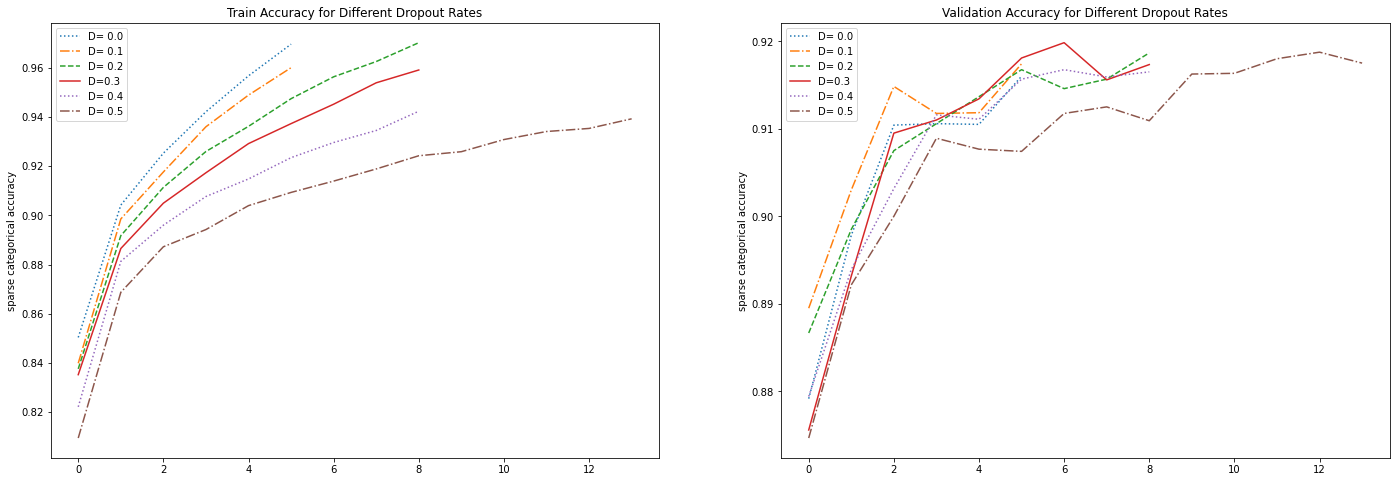

<Figure size 432x288 with 0 Axes>

In [60]:
plt.figure(figsize=(24,8))
plt.subplot(1, 2, 1)

for i in range(nets):
    plt.plot(output_list_d[i].history['sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Train Accuracy for Different Dropout Rates')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.subplot(1, 2, 2)
for i in range(nets):
    plt.plot(output_list_d[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Validation Accuracy for Different Dropout Rates')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1]) 
plt.show()

plt.savefig('droup_out.png');

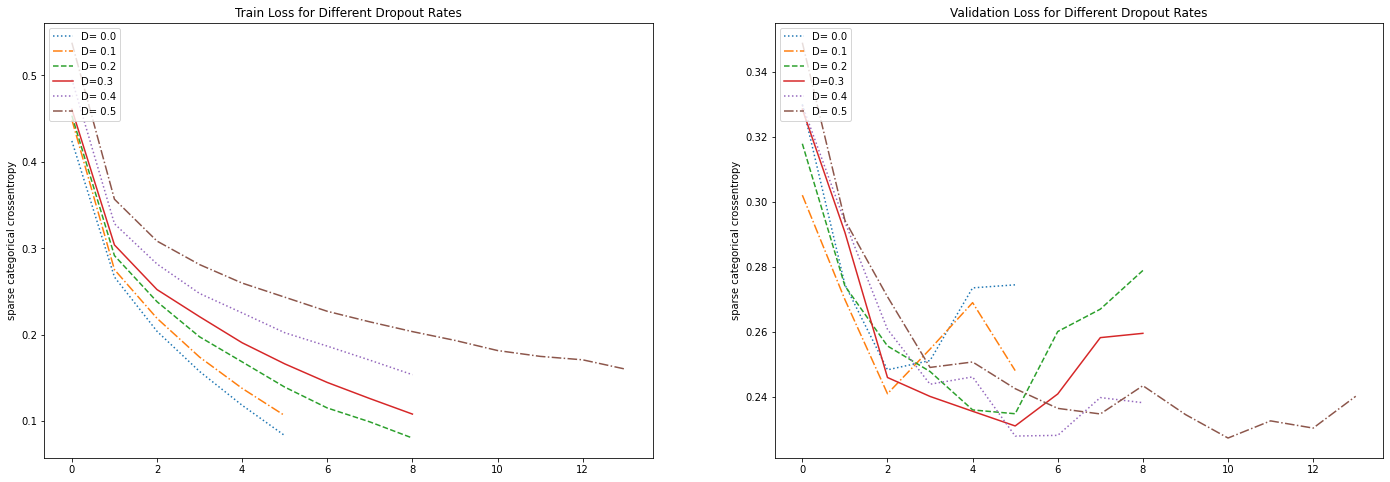

<Figure size 432x288 with 0 Axes>

In [61]:
plt.figure(figsize=(24,8))
plt.subplot(1, 2, 1)

for i in range(nets):
    plt.plot(output_list_d[i].history['loss'],linestyle=styles[i])

plt.title('Train Loss for Different Dropout Rates')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.subplot(1, 2, 2)
for i in range(nets):
    plt.plot(output_list_d[i].history['val_loss'],linestyle=styles[i])

plt.title('Validation Loss for Different Dropout Rates')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1]) 
plt.show()

plt.savefig('droup_out_loss.png');

**Evaluate Dropout Models**

In [62]:
lossd = np.zeros(6)
accuracyd= np.zeros(6)
for i in range(6):
  lossd[i], accuracyd[i] = d_model[i].evaluate(fx_test, fy_test)

313/313 [==============================] - 2s 8ms/step - loss: 0.2570 - sparse_categorical_accuracy: 0.9163


In [63]:
display(Markdown(f"This 2 CONV2D layer architecture with Dropout layers gives a test accuracy centered around {np.mean(accuracyd) :.3f}"),
        Markdown(f"The minimum is {min(accuracyd):.4f} and the maximum is {max(accuracyd) :.4f}"))

This 2 CONV2D layer architecture with Dropout layers gives a test accuracy centered around 0.914

The minimum is 0.9094 and the maximum is 0.9166

D=0.2 and D = 0.3 are slightly overfitting, as the model is underperforming on unseen data. Between D=0.4 and D=0.5, D= 0.5 seems best. Although they seem not to be the best for training data, they seem to be robust in validation data. However, regarding training time, the difference is negligeable and D=0.4 seems to be the ideal choice, unlike MNIST that used 0.5

### Regularization: Batch Normalization

In [64]:
#regularization, adding batch_norm to model

nets = 3
b_model = [0]*nets
output_list_b = []

start_full_b = time.time()

for j in range(nets):
    b_model[j] = tf.keras.models.Sequential()
    b_model[j].add(tf.keras.layers.Conv2D(24,kernel_size=5,padding='same',activation='relu',
          input_shape=(28,28,1)))
    if j == 0:
      b_model[j].add(tf.keras.layers.BatchNormalization())
      b_model[j].add(tf.keras.layers.Conv2D(24,kernel_size=5,padding='same',activation='relu'))
      b_model[j].add(tf.keras.layers.Flatten())
      b_model[j].add(tf.keras.layers.Dense(256, activation='relu'))

    if j == 1:
      b_model[j].add(tf.keras.layers.BatchNormalization())
      b_model[j].add(tf.keras.layers.Conv2D(24,kernel_size=5,padding='same',activation='relu'))
      b_model[j].add(tf.keras.layers.BatchNormalization())
      b_model[j].add(tf.keras.layers.Flatten())
      b_model[j].add(tf.keras.layers.Dense(256, activation='relu'))

    if j == 2:
      b_model[j].add(tf.keras.layers.BatchNormalization())
      b_model[j].add(tf.keras.layers.Conv2D(24,kernel_size=5,padding='same',activation='relu'))
      b_model[j].add(tf.keras.layers.BatchNormalization())
      b_model[j].add(tf.keras.layers.Flatten())
      b_model[j].add(tf.keras.layers.Dense(256, activation='relu'))
      b_model[j].add(tf.keras.layers.BatchNormalization())

    b_model[j].add(tf.keras.layers.Dense(10, activation='softmax'))
    b_model[j].compile(optimizer="adam",loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

    start = time.time()
    output_list_b.append(b_model[j].fit(fx_train, fy_train, epochs=100, batch_size=128, callbacks= [early_stop], validation_split= 0.2))
    end = time.time()
    display(Markdown(f"**Training time for {len(output_list_b[j].epoch)} epochs**: {(end-start): .3f}s"))

end_full_b= time.time()

Epoch 1/100
375/375 [==============================] - 50s 133ms/step - loss: 0.4385 - sparse_categorical_accuracy: 0.8531 - val_loss: 1.0480 - val_sparse_categorical_accuracy: 0.8825
Epoch 2/100
375/375 [==============================] - 50s 133ms/step - loss: 0.2445 - sparse_categorical_accuracy: 0.9097 - val_loss: 0.2756 - val_sparse_categorical_accuracy: 0.8962
Epoch 3/100
375/375 [==============================] - 48s 129ms/step - loss: 0.1795 - sparse_categorical_accuracy: 0.9339 - val_loss: 0.2663 - val_sparse_categorical_accuracy: 0.9020
Epoch 4/100
375/375 [==============================] - 48s 129ms/step - loss: 0.1314 - sparse_categorical_accuracy: 0.9520 - val_loss: 0.2861 - val_sparse_categorical_accuracy: 0.9062
Epoch 5/100
375/375 [==============================] - 48s 128ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.2822 - val_sparse_categorical_accuracy: 0.9065
Epoch 6/100
375/375 [==============================] - 48s 128ms/step - loss: 0.

**Training time for 6 epochs**:  292.782s

Epoch 1/100
375/375 [==============================] - 53s 139ms/step - loss: 0.4692 - sparse_categorical_accuracy: 0.8561 - val_loss: 1.4804 - val_sparse_categorical_accuracy: 0.5136
Epoch 2/100
375/375 [==============================] - 52s 140ms/step - loss: 0.2397 - sparse_categorical_accuracy: 0.9107 - val_loss: 0.2864 - val_sparse_categorical_accuracy: 0.8954
Epoch 3/100
375/375 [==============================] - 52s 138ms/step - loss: 0.1790 - sparse_categorical_accuracy: 0.9327 - val_loss: 0.2726 - val_sparse_categorical_accuracy: 0.9012
Epoch 4/100
375/375 [==============================] - 52s 138ms/step - loss: 0.1322 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.2800 - val_sparse_categorical_accuracy: 0.9065
Epoch 5/100
375/375 [==============================] - 52s 138ms/step - loss: 0.0981 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.3952 - val_sparse_categorical_accuracy: 0.8913
Epoch 6/100
375/375 [==============================] - 52s 138ms/step - loss: 0.

**Training time for 6 epochs**:  311.858s

Epoch 1/100
375/375 [==============================] - 51s 133ms/step - loss: 0.3741 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.8536 - val_sparse_categorical_accuracy: 0.7592
Epoch 2/100
375/375 [==============================] - 50s 132ms/step - loss: 0.2455 - sparse_categorical_accuracy: 0.9096 - val_loss: 0.2666 - val_sparse_categorical_accuracy: 0.9047
Epoch 3/100
375/375 [==============================] - 50s 132ms/step - loss: 0.1865 - sparse_categorical_accuracy: 0.9313 - val_loss: 0.2738 - val_sparse_categorical_accuracy: 0.9022
Epoch 4/100
375/375 [==============================] - 50s 132ms/step - loss: 0.1413 - sparse_categorical_accuracy: 0.9468 - val_loss: 0.2803 - val_sparse_categorical_accuracy: 0.9039
Epoch 5/100
375/375 [==============================] - 50s 132ms/step - loss: 0.1075 - sparse_categorical_accuracy: 0.9609 - val_loss: 0.2680 - val_sparse_categorical_accuracy: 0.9148


**Training time for 5 epochs**:  249.046s

In [65]:
display(Markdown(f"**Total training time for 3 different BNs**: {(end_full_b -start_full_b): .3f}s; {(end_full_b -start_full_b)/60 : .3f}m"))

**Total training time for 3 different BNs**:  853.894s;  14.232m

In [66]:
t_epochs = np.zeros(3)
names = ["1 BN", "2 BN", "3 BN"]

for i in range(3):
    t_epochs[i] = len(output_list_b[i].epoch)
    display(Markdown(f"**{names[i]} :** {t_epochs[i]} epochs to converge"))

display(Markdown(f"The shortest was {min(t_epochs)} and the longest was {max(t_epochs)}"))

**1 BN :** 6.0 epochs to converge

**2 BN :** 6.0 epochs to converge

**3 BN :** 5.0 epochs to converge

The shortest was 5.0 and the longest was 6.0

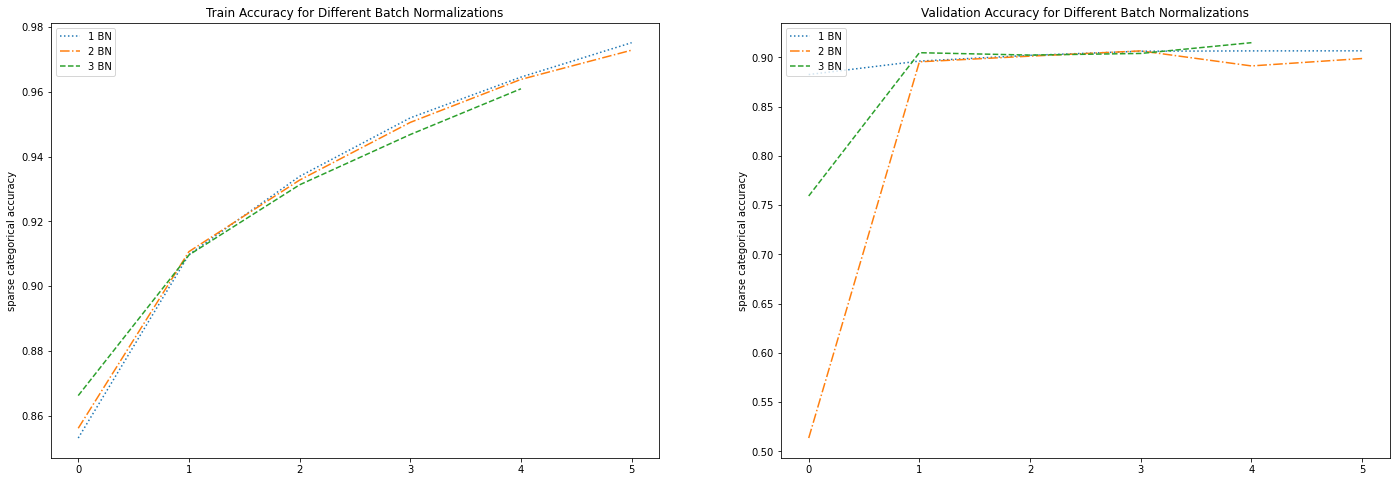

<Figure size 432x288 with 0 Axes>

In [67]:
plt.figure(figsize=(24,8))

plt.subplot(1, 2, 1)
for i in range(nets):
    plt.plot(output_list_b[i].history['sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Train Accuracy for Different Batch Normalizations')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.subplot(1, 2, 2)
for i in range(nets):
    plt.plot(output_list_b[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Validation Accuracy for Different Batch Normalizations')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1]) 
plt.show()

plt.savefig('batch_norm.png');

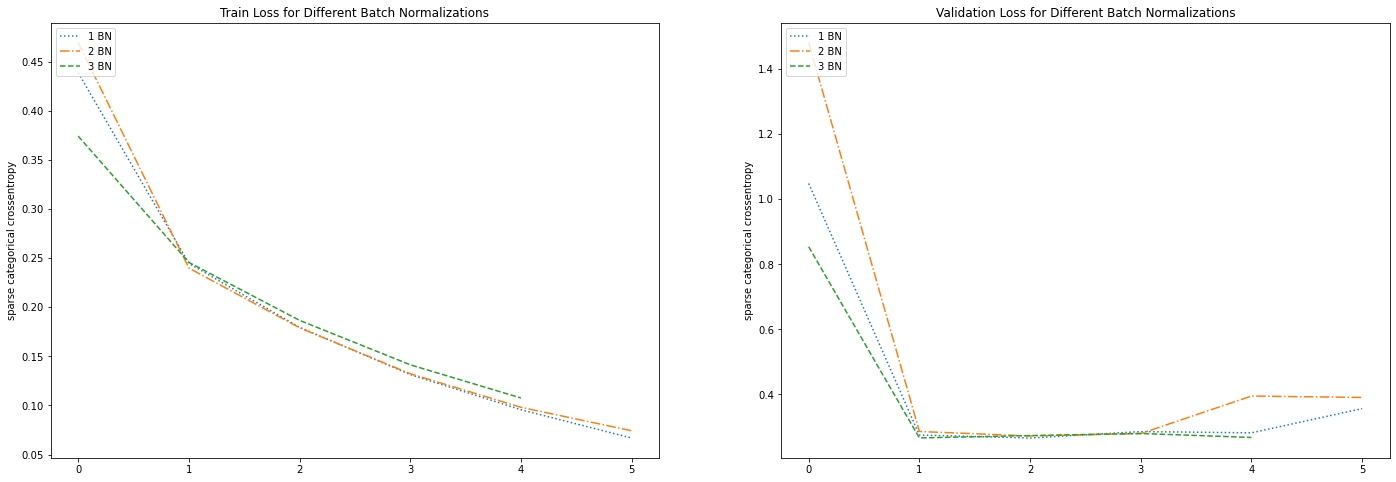

<Figure size 432x288 with 0 Axes>

In [68]:
plt.figure(figsize=(24,8))

plt.subplot(1, 2, 1)
for i in range(nets):
    plt.plot(output_list_b[i].history['loss'],linestyle=styles[i])

plt.title('Train Loss for Different Batch Normalizations')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.subplot(1, 2, 2)
for i in range(nets):
    plt.plot(output_list_b[i].history['val_loss'],linestyle=styles[i])

plt.title('Validation Loss for Different Batch Normalizations')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1]) 
plt.show()

plt.savefig('batch_norm_loss.png');

In [69]:
lossb = np.zeros(3)
accuracyb= np.zeros(3)
for i in range(3):
  lossb[i], accuracyb[i] = b_model[i].evaluate(fx_test, fy_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.2848 - sparse_categorical_accuracy: 0.9127


In [70]:
display(Markdown(f"This 2 CONV2D layer architecture with different BatchNorm layers gives a test accuracy centered around {np.mean(accuracyb) :.3f}"),
        Markdown(f"The minimum is {min(accuracyb):.4f} and the maximum is {max(accuracyb) :.4f}"))

This 2 CONV2D layer architecture with different BatchNorm layers gives a test accuracy centered around 0.906

The minimum is 0.8965 and the maximum is 0.9127

Adding Batch Normalization after each activation layer seems best. The model definitely improved after adding Batch Normalization. The Validation plot looks much more stable after Batch Normalization.

**Dropout and Batch Normalization Choice:** D=0.4, 3BN

### Optimizers

In [71]:
#OPTIMIZER 3 different learning rates using adam
nets = 3
o_model = [0]*nets
optimizers = [tf.keras.optimizers.Adam(1e-2),tf.keras.optimizers.Adam(1e-3),tf.keras.optimizers.Adam(1e-4)]
output_list_o = []

start_full_o = time.time()
for j in range(nets):
    o_model[j] = tf.keras.models.Sequential()
    o_model[j].add(tf.keras.layers.Conv2D(24,kernel_size=5,padding='same',activation='relu',
              input_shape=(28,28,1)))
    o_model[j].add(tf.keras.layers.Dropout(0.4))
    o_model[j].add(tf.keras.layers.BatchNormalization())

    o_model[j].add(tf.keras.layers.Conv2D(24,kernel_size=5,padding='same',activation='relu'))
    o_model[j].add(tf.keras.layers.Dropout(0.4))
    o_model[j].add(tf.keras.layers.BatchNormalization())


    o_model[j].add(tf.keras.layers.Flatten())
    o_model[j].add(tf.keras.layers.Dense(256, activation='relu'))
    o_model[j].add(tf.keras.layers.Dropout(0.4))
    o_model[j].add(tf.keras.layers.BatchNormalization())

    o_model[j].add(tf.keras.layers.Dense(10, activation='softmax'))
    o_model[j].compile(optimizer=optimizers[j],loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

    start= time.time()
    output_list_o.append(o_model[j].fit(fx_train, fy_train, epochs=100, batch_size=128, callbacks= [early_stop], validation_split= 0.2))
    end = time.time()

    display(Markdown(f"**Training time for {len(output_list_o[j].epoch)} epochs**: {(end-start): .3f}s"))

end_full_o = time.time()

Epoch 1/100
375/375 [==============================] - 62s 165ms/step - loss: 0.4869 - sparse_categorical_accuracy: 0.8228 - val_loss: 0.7015 - val_sparse_categorical_accuracy: 0.7481
Epoch 2/100
375/375 [==============================] - 61s 162ms/step - loss: 0.3463 - sparse_categorical_accuracy: 0.8724 - val_loss: 0.2993 - val_sparse_categorical_accuracy: 0.8907
Epoch 3/100
375/375 [==============================] - 62s 164ms/step - loss: 0.3639 - sparse_categorical_accuracy: 0.8633 - val_loss: 0.2896 - val_sparse_categorical_accuracy: 0.8922
Epoch 4/100
375/375 [==============================] - 61s 162ms/step - loss: 0.2955 - sparse_categorical_accuracy: 0.8890 - val_loss: 0.2703 - val_sparse_categorical_accuracy: 0.8969
Epoch 5/100
375/375 [==============================] - 61s 164ms/step - loss: 0.2700 - sparse_categorical_accuracy: 0.9002 - val_loss: 0.3093 - val_sparse_categorical_accuracy: 0.8903
Epoch 6/100
375/375 [==============================] - 61s 162ms/step - loss: 0.

**Training time for 15 epochs**:  913.087s

Epoch 1/100
375/375 [==============================] - 61s 161ms/step - loss: 0.4549 - sparse_categorical_accuracy: 0.8365 - val_loss: 1.0233 - val_sparse_categorical_accuracy: 0.6072
Epoch 2/100
375/375 [==============================] - 61s 162ms/step - loss: 0.3087 - sparse_categorical_accuracy: 0.8871 - val_loss: 0.2828 - val_sparse_categorical_accuracy: 0.8917
Epoch 3/100
375/375 [==============================] - 61s 162ms/step - loss: 0.2686 - sparse_categorical_accuracy: 0.9006 - val_loss: 0.2402 - val_sparse_categorical_accuracy: 0.9098
Epoch 4/100
375/375 [==============================] - 61s 162ms/step - loss: 0.2405 - sparse_categorical_accuracy: 0.9109 - val_loss: 0.2271 - val_sparse_categorical_accuracy: 0.9150
Epoch 5/100
375/375 [==============================] - 61s 162ms/step - loss: 0.2215 - sparse_categorical_accuracy: 0.9178 - val_loss: 0.2400 - val_sparse_categorical_accuracy: 0.9128
Epoch 6/100
375/375 [==============================] - 61s 162ms/step - loss: 0.

**Training time for 10 epochs**:  608.116s

Epoch 1/100
375/375 [==============================] - 61s 162ms/step - loss: 0.6395 - sparse_categorical_accuracy: 0.7756 - val_loss: 0.8482 - val_sparse_categorical_accuracy: 0.7043
Epoch 2/100
375/375 [==============================] - 60s 160ms/step - loss: 0.4298 - sparse_categorical_accuracy: 0.8457 - val_loss: 0.3437 - val_sparse_categorical_accuracy: 0.8737
Epoch 3/100
375/375 [==============================] - 60s 161ms/step - loss: 0.3734 - sparse_categorical_accuracy: 0.8666 - val_loss: 0.3114 - val_sparse_categorical_accuracy: 0.8853
Epoch 4/100
375/375 [==============================] - 60s 161ms/step - loss: 0.3370 - sparse_categorical_accuracy: 0.8776 - val_loss: 0.2962 - val_sparse_categorical_accuracy: 0.8897
Epoch 5/100
375/375 [==============================] - 61s 162ms/step - loss: 0.3108 - sparse_categorical_accuracy: 0.8870 - val_loss: 0.2680 - val_sparse_categorical_accuracy: 0.9010
Epoch 6/100
375/375 [==============================] - 61s 162ms/step - loss: 0.

**Training time for 24 epochs**:  1442.182s

In [72]:
display(Markdown(f"**Total training time for 3 Learning rates**: {(end_full_o -start_full_o): .3f}s; {(end_full_o -start_full_o)/60 : .3f}m "))

**Total training time for 3 Learning rates**:  2963.627s;  49.394m 

In [73]:
t_epochs = np.zeros(3)
names = ["Adam(1e-2)", "Adam(1e-3)", "Adam(1e-4)"]

for i in range(3):
    t_epochs[i] = len(output_list_o[i].epoch)
    display(Markdown(f"**{names[i]} :** {t_epochs[i]} epochs to converge"))

**Adam(1e-2) :** 15.0 epochs to converge

**Adam(1e-3) :** 10.0 epochs to converge

**Adam(1e-4) :** 24.0 epochs to converge

Obviously, we can see that smaller learning rates takes longer to converge, since they are taking smaller steps. Butit is unexpected that Adam(1e-2) took more to converge than Adam(1e-3).

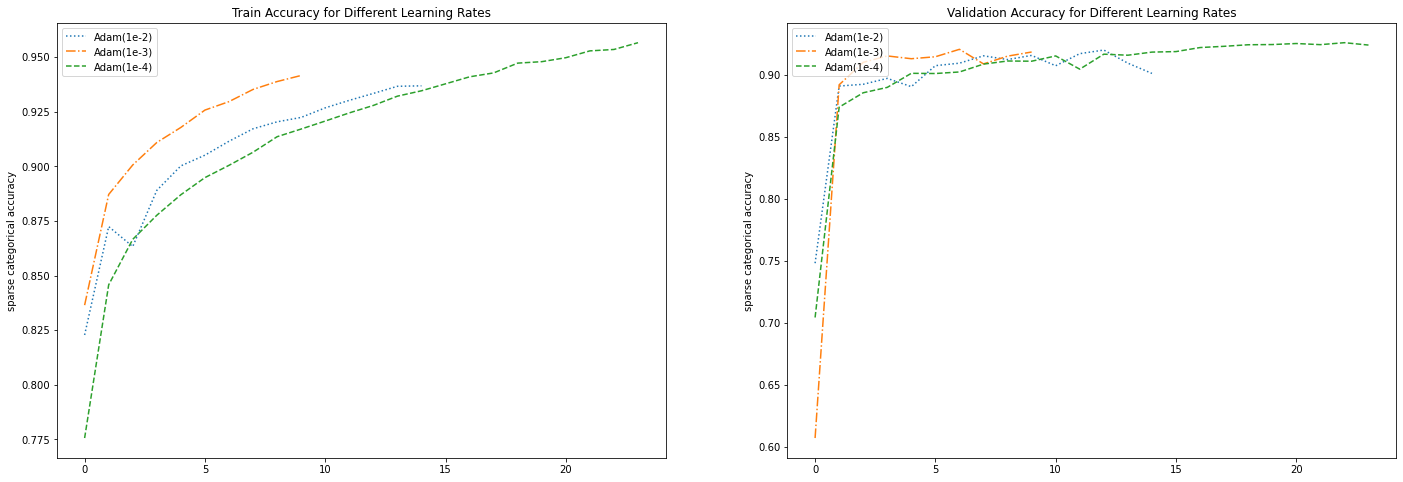

<Figure size 432x288 with 0 Axes>

In [76]:
plt.figure(figsize=(24,8))

plt.subplot(1, 2, 1)
for i in range(nets):
    plt.plot(output_list_o[i].history['sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Train Accuracy for Different Learning Rates')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.subplot(1, 2, 2)
for i in range(nets):
    plt.plot(output_list_o[i].history['val_sparse_categorical_accuracy'],linestyle=styles[i])

plt.title('Validation Accuracy for Different Learning Rates')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1]) 
plt.show()

plt.savefig('opt.png');

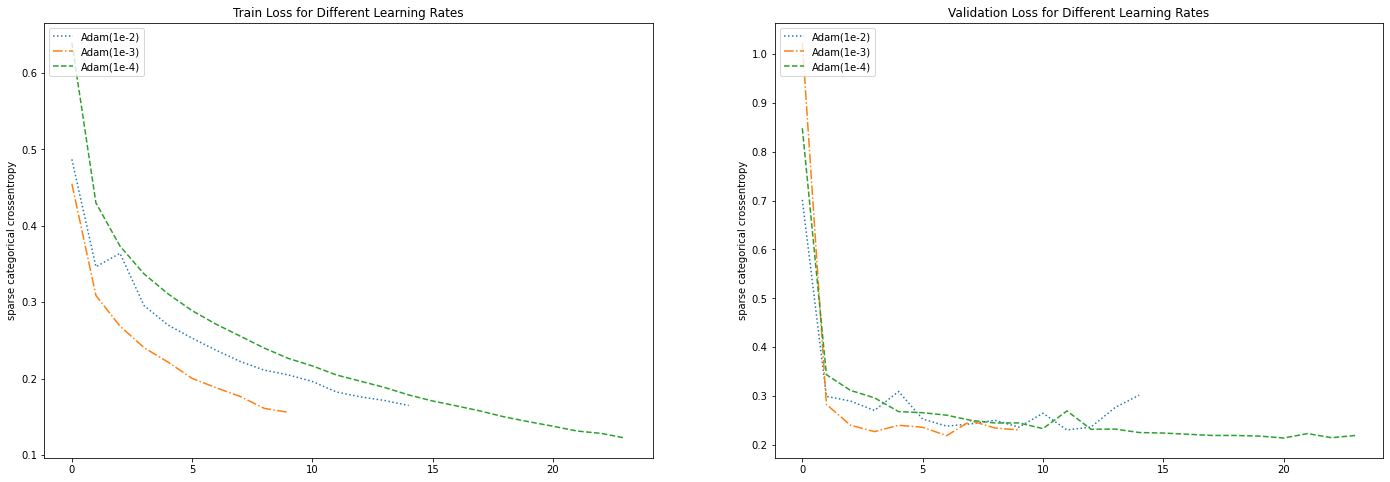

<Figure size 432x288 with 0 Axes>

In [75]:
plt.figure(figsize=(24,8))

plt.subplot(1, 2, 1)
for i in range(nets):
    plt.plot(output_list_o[i].history['loss'],linestyle=styles[i])

plt.title('Train Loss for Different Learning Rates')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])

plt.subplot(1, 2, 2)
for i in range(nets):
    plt.plot(output_list_o[i].history['val_loss'],linestyle=styles[i])

plt.title('Validation Loss for Different Learning Rates')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1]) 
plt.show()

plt.savefig('opt_loss.png');

**Evaluate Optimizers**

In [77]:
losso = np.zeros(3)
accuracyo = np.zeros(3)
for i in range(3):
  losso[i], accuracyo[i] = o_model[i].evaluate(fx_test, fy_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.2361 - sparse_categorical_accuracy: 0.9201


In [78]:
display(Markdown(f"This 2 CONV2D layer architecture with different Optimizer Learning Rates gives a test accuracy centered around {np.mean(accuracyo) :.3f}"),
        Markdown(f"The minimum is {min(accuracyo):.4f} and the maximum is {max(accuracyo) :.4f}"))

This 2 CONV2D layer architecture with different Optimizer Learning Rates gives a test accuracy centered around 0.912

The minimum is 0.9001 and the maximum is 0.9201

It seems that learning rate of 1e-4 is doing best in training and validation, but is only slightly better than 1e-3.
We choose 1e-3 again, considering the training time.

### MaxPooling

Why to use Pooling Layers?

- Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network.
- The pooling layer summarises the features present in a region of the feature map generated by a convolution layer. So, further operations are performed on summarised features instead of precisely positioned features generated by the convolution layer. This makes the model more robust to variations in the position of the features in the input image. 

`tf.keras.layers.MaxPool2D(pool_size=(2,2))` is default pool size

In [79]:

start_full_m = time.time()

m_model = tf.keras.models.Sequential()
m_model.add(tf.keras.layers.Conv2D(24,kernel_size=5,padding='same',activation='relu',
          input_shape=(28,28,1)))
m_model.add(tf.keras.layers.BatchNormalization())
m_model.add(tf.keras.layers.MaxPool2D())
m_model.add(tf.keras.layers.Dropout(0.5))

m_model.add(tf.keras.layers.Conv2D(24,kernel_size=5,padding='same',activation='relu'))
m_model.add(tf.keras.layers.BatchNormalization())
m_model.add(tf.keras.layers.MaxPool2D())
m_model.add(tf.keras.layers.Dropout(0.5))

m_model.add(tf.keras.layers.Flatten())
m_model.add(tf.keras.layers.Dense(256, activation='relu'))
m_model.add(tf.keras.layers.BatchNormalization())
m_model.add(tf.keras.layers.Dropout(0.5))

m_model.add(tf.keras.layers.Dense(10, activation='softmax'))
m_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

start= time.time()
output_list_m = m_model.fit(fx_train, fy_train, epochs=100, batch_size=128, callbacks= [early_stop], validation_split= 0.2)
end = time.time()

display(Markdown(f"**Training time for {len(output_list_m.epoch)} epochs**: {(end-start): .3f}s"))

end_full_m = time.time()

Epoch 1/100
375/375 [==============================] - 24s 63ms/step - loss: 0.7281 - sparse_categorical_accuracy: 0.7472 - val_loss: 1.3412 - val_sparse_categorical_accuracy: 0.5271
Epoch 2/100
375/375 [==============================] - 23s 62ms/step - loss: 0.4768 - sparse_categorical_accuracy: 0.8271 - val_loss: 0.3684 - val_sparse_categorical_accuracy: 0.8639
Epoch 3/100
375/375 [==============================] - 23s 61ms/step - loss: 0.4150 - sparse_categorical_accuracy: 0.8462 - val_loss: 0.3247 - val_sparse_categorical_accuracy: 0.8799
Epoch 4/100
375/375 [==============================] - 23s 61ms/step - loss: 0.3807 - sparse_categorical_accuracy: 0.8594 - val_loss: 0.3372 - val_sparse_categorical_accuracy: 0.8724
Epoch 5/100
375/375 [==============================] - 23s 61ms/step - loss: 0.3638 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.2885 - val_sparse_categorical_accuracy: 0.8916
Epoch 6/100
375/375 [==============================] - 23s 61ms/step - loss: 0.3461 -

**Training time for 21 epochs**:  482.609s

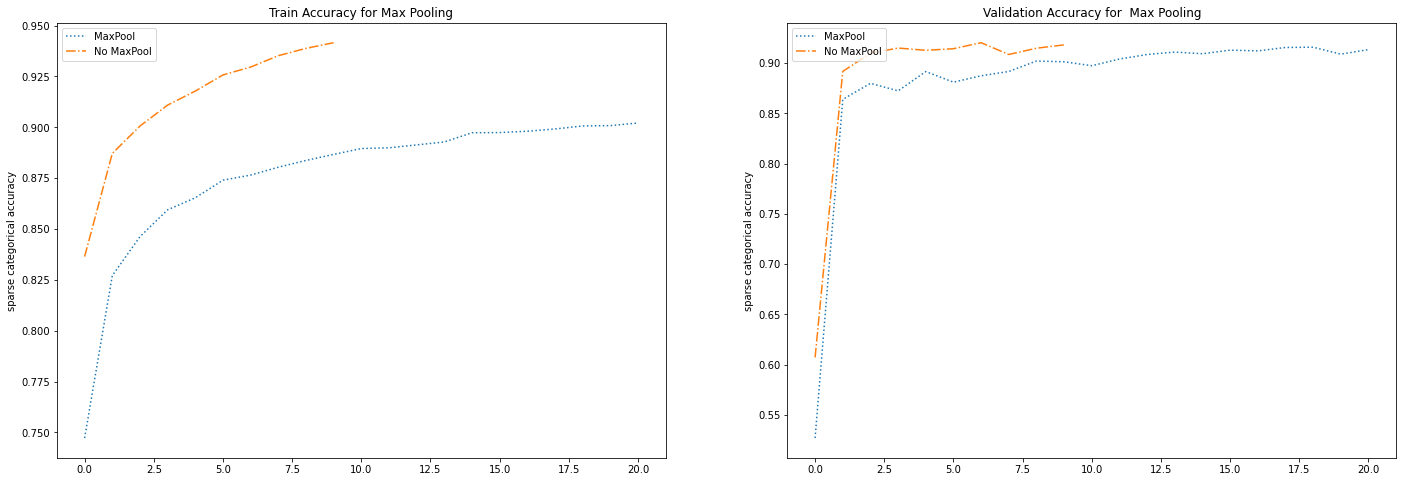

<Figure size 432x288 with 0 Axes>

In [81]:
plt.figure(figsize=(24,8))

plt.subplot(1, 2, 1)

plt.plot(output_list_m.history['sparse_categorical_accuracy'],linestyle=styles[0])
plt.plot(output_list_o[1].history['sparse_categorical_accuracy'],linestyle=styles[1])

plt.title('Train Accuracy for Max Pooling')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(['MaxPool', 'No MaxPool'], loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])


plt.subplot(1, 2, 2)

plt.plot(output_list_m.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.plot(output_list_o[1].history['val_sparse_categorical_accuracy'],linestyle=styles[1])

plt.title('Validation Accuracy for  Max Pooling')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(['MaxPool', 'No MaxPool'], loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1]) 
plt.show()

plt.savefig('maxpool.png');

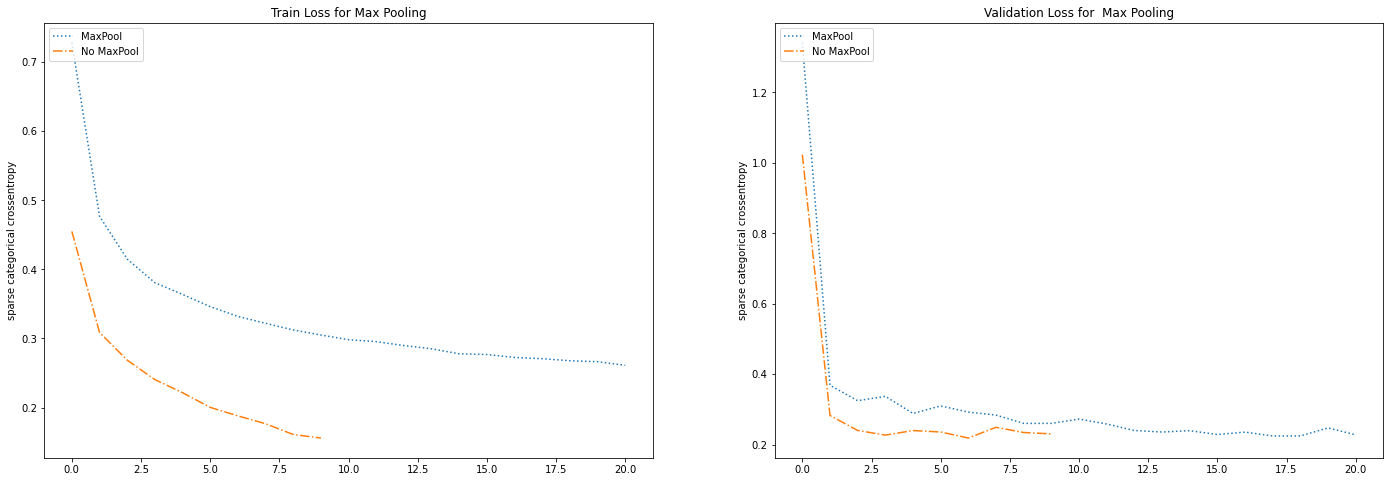

<Figure size 432x288 with 0 Axes>

In [82]:
plt.figure(figsize=(24,8))

plt.subplot(1, 2, 1)

plt.plot(output_list_m.history['loss'],linestyle=styles[0])
plt.plot(output_list_o[1].history['loss'],linestyle=styles[1])

plt.title('Train Loss for Max Pooling')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(['MaxPool', 'No MaxPool'], loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])


plt.subplot(1, 2, 2)

plt.plot(output_list_m.history['val_loss'],linestyle=styles[0])
plt.plot(output_list_o[1].history['val_loss'],linestyle=styles[1])

plt.title('Validation Loss for  Max Pooling')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(['MaxPool', 'No MaxPool'], loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1]) 
plt.show()

plt.savefig('maxpool_loss.png');

**Evaluate MaxPool**


In [83]:
maxloss, maxaccuracy = m_model.evaluate(fx_test, fy_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.2446 - sparse_categorical_accuracy: 0.9094


In [86]:
display(Markdown(f"This 2 CONV2D layer architecture with MaxPooling gives a test accuracy of {maxaccuracy :.4f} compared to {accuracyo[1] : .4f} without MaxPooling"))

This 2 CONV2D layer architecture with MaxPooling gives a test accuracy of 0.9094 compared to  0.9158 without MaxPooling

They are both overfitting: while the training accuracy is much higher for no MaxPooling, the validation accuracy is similar which implies that the MaxPool gives the model more stability. However, since the model seems to be over fitting, I will try to change the patience to 3 like the MNIST dataset and add striding to the model and compare.

In [87]:
early_stop_new = tf.keras.callbacks.EarlyStopping(patience=3)

start_full_new = time.time()

new_model = tf.keras.models.Sequential()
new_model.add(tf.keras.layers.Conv2D(24,kernel_size=5, padding='same', strides=(2,2),activation='relu',
          input_shape=(28,28,1)))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.MaxPool2D())
new_model.add(tf.keras.layers.Dropout(0.5))

new_model.add(tf.keras.layers.Conv2D(24,kernel_size=5, padding='same', strides=(2,2), activation='relu'))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.MaxPool2D())
new_model.add(tf.keras.layers.Dropout(0.5))

new_model.add(tf.keras.layers.Flatten())
new_model.add(tf.keras.layers.Dense(256, activation='relu'))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Dropout(0.5))

new_model.add(tf.keras.layers.Dense(10, activation='softmax'))
new_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

start= time.time()
output_list_new = new_model.fit(fx_train, fy_train, epochs=100, batch_size=128, callbacks= [early_stop_new], validation_split= 0.2)
end = time.time()

display(Markdown(f"**Training time for {len(output_list_new.epoch)} epochs**: {(end-start): .3f}s"))

end_full_new = time.time()

Epoch 1/100
375/375 [==============================] - 6s 16ms/step - loss: 1.1566 - sparse_categorical_accuracy: 0.5991 - val_loss: 1.0661 - val_sparse_categorical_accuracy: 0.6630
Epoch 2/100
375/375 [==============================] - 6s 16ms/step - loss: 0.6918 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.4773 - val_sparse_categorical_accuracy: 0.8236
Epoch 3/100
375/375 [==============================] - 6s 16ms/step - loss: 0.6014 - sparse_categorical_accuracy: 0.7764 - val_loss: 0.4302 - val_sparse_categorical_accuracy: 0.8361
Epoch 4/100
375/375 [==============================] - 6s 15ms/step - loss: 0.5578 - sparse_categorical_accuracy: 0.7954 - val_loss: 0.3978 - val_sparse_categorical_accuracy: 0.8511
Epoch 5/100
375/375 [==============================] - 6s 16ms/step - loss: 0.5250 - sparse_categorical_accuracy: 0.8066 - val_loss: 0.3854 - val_sparse_categorical_accuracy: 0.8541
Epoch 6/100
375/375 [==============================] - 6s 15ms/step - loss: 0.5032 - spars

**Training time for 20 epochs**:  119.581s

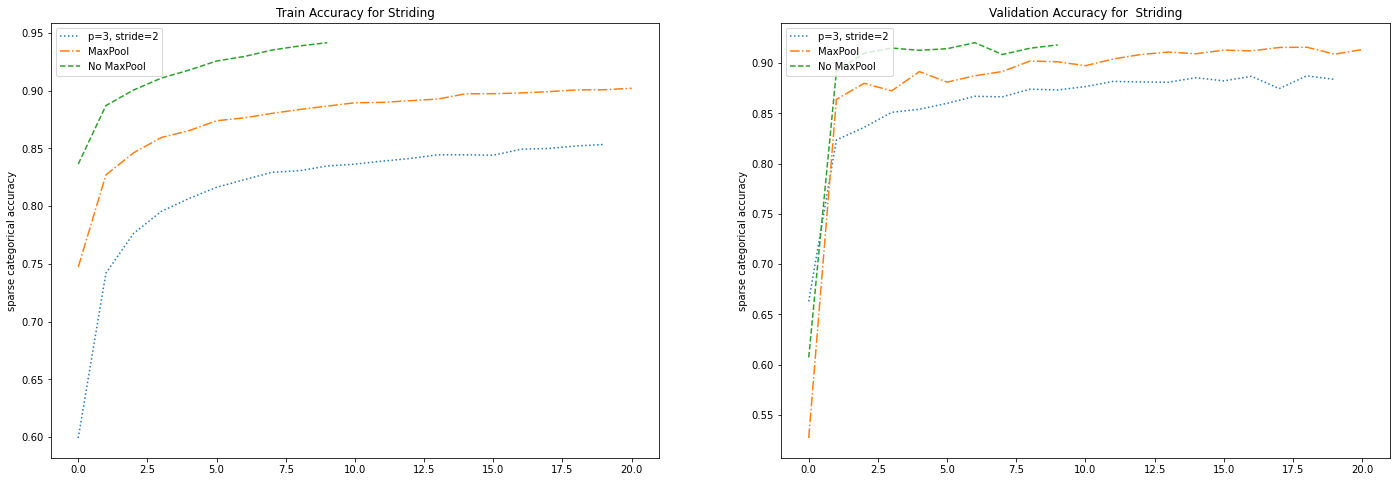

<Figure size 432x288 with 0 Axes>

In [91]:
plt.figure(figsize=(24,8))

plt.subplot(1, 2, 1)

plt.plot(output_list_new.history['sparse_categorical_accuracy'],linestyle=styles[0])
plt.plot(output_list_m.history['sparse_categorical_accuracy'],linestyle=styles[1])
plt.plot(output_list_o[1].history['sparse_categorical_accuracy'],linestyle=styles[2])

plt.title('Train Accuracy for Striding')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(['p=3, stride=2','MaxPool', 'No MaxPool'], loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])


plt.subplot(1, 2, 2)
plt.plot(output_list_new.history['val_sparse_categorical_accuracy'],linestyle=styles[0])
plt.plot(output_list_m.history['val_sparse_categorical_accuracy'],linestyle=styles[1])
plt.plot(output_list_o[1].history['val_sparse_categorical_accuracy'],linestyle=styles[2])

plt.title('Validation Accuracy for  Striding')
plt.ylabel('sparse categorical accuracy')
#plt.xlabel('epoch')
plt.legend(['p=3, stride=2','MaxPool', 'No MaxPool'], loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1]) 
plt.show()

plt.savefig('new.png');

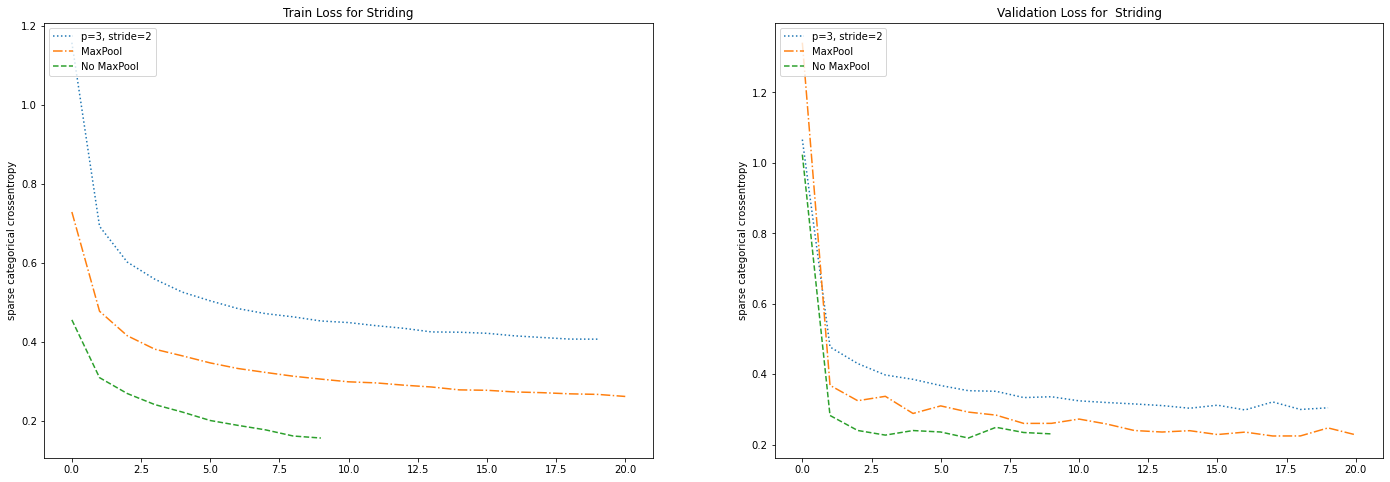

<Figure size 432x288 with 0 Axes>

In [90]:
plt.figure(figsize=(24,8))

plt.subplot(1, 2, 1)

plt.plot(output_list_new.history['loss'],linestyle=styles[0])
plt.plot(output_list_m.history['loss'],linestyle=styles[1])
plt.plot(output_list_o[1].history['loss'],linestyle=styles[2])

plt.title('Train Loss for Striding')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(['p=3, stride=2','MaxPool', 'No MaxPool'], loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1])


plt.subplot(1, 2, 2)
plt.plot(output_list_new.history['val_loss'],linestyle=styles[0])
plt.plot(output_list_m.history['val_loss'],linestyle=styles[1])
plt.plot(output_list_o[1].history['val_loss'],linestyle=styles[2])

plt.title('Validation Loss for  Striding')
plt.ylabel('sparse categorical crossentropy')
#plt.xlabel('epoch')
plt.legend(['p=3, stride=2','MaxPool', 'No MaxPool'], loc='upper left')
axes = plt.gca()
#axes.set_ylim([0.98,1]) 
plt.show()

plt.savefig('new_loss.png');

**Evaluate MaxPool**


In [93]:
newloss, newaccuracy = new_model.evaluate(fx_test, fy_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3271 - sparse_categorical_accuracy: 0.8798


In [94]:
display(Markdown(f"This new 2 CONV2D layer architecture gives a test accuracy of {newaccuracy :.4f} compared to {maxaccuracy : .4f}"))

This new 2 CONV2D layer architecture gives a test accuracy of 0.8798 compared to  0.9094

The new params did not solve overfitting problem, nor did the test accuracy improve.

### Best Model
The best model for the Fashion-MNIST data looks like this:

In [96]:
m_model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 28, 28, 24)        624       
                                                                 
 batch_normalization_15 (Bat  (None, 28, 28, 24)       96        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 24)       0         
 )                                                               
                                                                 
 dropout_27 (Dropout)        (None, 14, 14, 24)        0         
                                                                 
 conv2d_79 (Conv2D)          (None, 14, 14, 24)        14424     
                                                                 
 batch_normalization_16 (Bat  (None, 14, 14, 24)     

### Results

The model built is surely underperforming for the fashion MNIST data than on the MNIST data. While on the MNIST data showed high level of accuracy, averaging around 0.98 to 0.99, for the fashion MNIST data is centered around 0.90 to 0.92. It might be that the fashion MNIST images have more features than the handwritten digits.